In [80]:
# matplotlib stuff: plots inline:
%matplotlib inline
# stop autosaving it messes up with git!
%autosave 0
# I dont know what I wanted to do here (some plot optimization with macOS?):
%config InlineBackend.figure_format = 'retina'

import os
CWD = os.getcwd()
# DEFINE THE OUTPUT DIRECTORY OF THE FIGURES:
FIGURES_DESTDIR = os.path.join(os.path.dirname(os.path.dirname(CWD)), 'tmp')
FIG_DEFAULT_EXT = 'jpg'

# some checks:
assert os.path.isdir(FIGURES_DESTDIR), "There should be a top-level 'tmp' directory in the same directory as the README file), but the directory wasn't found. Did you run the jupyter notebook from within tehjupyter directory?"


# Import utils.py:
# 1. make this path in the pythonpath
import sys
sys.path.append(os.path.dirname(os.path.dirname(CWD)))
# 2. Import utils.py and reload it (so that we can fixing stuff there does not need notebook reload)
import importlib
from sdaas_eval.jupyter import utils
importlib.reload(utils)
# import all utility functions so that we can call them here directly by name:
from sdaas_eval.jupyter.utils import *
# Setup defaults, print a short doicumentation :
setup()

Setting pandas defaults

Value
display.max_colwidth    500
display.max_columns     500
display.max_rows         25

Setting matplotlib defaults

Value
figure.figsize   (6.29922, 6.29922)
lines.linewidth                 1.5
font.size                        10
axes.titlesize                   10
figure.dpi                      300
font.family              sans-serif

`sdaas_eval.jupyter.utils` cheat sheet

When using the module in a Jupyter Notebook, note the following naming
conventions: eval_df denotes an Evaluation Data frame, i.e. a
tabular object where a row is a model evaluation and columns report
evaluation info, e.g., model name, model hyperparams, testset file path,
some evaluation metrics scores. pred_df denotes a Prediction Data frame representing a model evaluation
in details: a row is a testset instance and columns
report several instance info, including the instance actual class as boolean
(column 'outlier') and the predicted class/score as float in [0, 1] (column
'predicted_anomaly_score') Given the above definitions, sdaas_eval.jupyter.utils imported the following functions/classes/modules that you can use in this Notebook: join Join two or more pathname components, inserting '/' as needed abspath Return an absolute path. dirname Returns the directory component of a pathname isfile Test whether a path is a regular file isdir Return true if the pathname refers to an existing directory. basename Returns the final component of a pathname splitext Split the extension from a pathname expanduser Expand ~ and ~user constructions isabs Test whether a path is absolute sys This module provides access to some objects used or maintained by the os OS routines for NT or Posix depending on what system we're on re Support for regular expressions (RE) time This module provides various functions to manipulate time values inspect Get useful information from live Python objects datetime datetime(year, month, day[, hour[, minute[, second[, microsecond[,tzinfo]]]]]) timedelta Difference between two datetime values contextlib Utilities for with-statement contexts Enum Generic enumeration defaultdict defaultdict(default_factory[, ...]) --> dict with default factory namedtuple Returns a new subclass of tuple with named fields np NumPy matplotlib An object-oriented plotting library plt `matplotlib.pyplot` is a state-based interface to matplotlib hmean Calculate the harmonic mean along the specified axis metrics The :mod:`sklearn.metrics` module includes score functions, performance metrics dump Persist an arbitrary Python object into one file load Reconstruct a Python object from a file persisted with joblib.dump display Display a Python object in all frontends display_html Display the HTML representation of an object clear_output Clear the output of the current cell receiving output pd pandas - a powerful data analysis and manipulation library for Python cycle Return elements from the iterable until it is exhausted importlib A pure Python implementation of import. MultipleLocator Set a tick on each integer multiple of a base within the view interval. psd_values Calculate the power spectral density (PSD) of the given Segment Model representing a Waveform segment Station Model representing a Station g_s Create and returns an sql alchemy session for IO db operations aiming to yaml setup setup_pandas_defaults setup_matplotlib_defaults printdoc Prints this table as HTML formatted text (to be used in a Notebook) savefig Save a figure for the paper in a dedicated folder. The format will be
inferred from the file path extension dbsession with dbsession(dbname_or_dbid) as session: printhtml Same as display_html(text, True): prints the html formatted text
passed as argument EVALMETRICS Evaluation metrics enumeration. Each enum item is mapped to a string:
 AUC = 'roc_auc_score'
 APS = 'average_precision_score'
 LOGLOSS = 'log_loss'
 F1MAX = 'f1_max' (F1score at BEST_TH_PR )
 PMAX = 'p_max' (Precision at BEST_TH_PR )
 RMAX = 'r_max' (Recall at BEST_TH_PR )
 BEST_TH_PR 
 and has a compute method
(e.g., EVALMETRICS.APS.compute(pred_df) ) which
returns the metric scalar value from a prediction dataframe read_summary_eval_df read_summary_eval_df(**kwargs) = pandas
 read_hdf('../evaluations/results/summary_evaluationmetrics.hdf', **kwargs) 
reads and returns the Evaluation dataframe created and incremented by each
execution of the main script evaluate.py

In [65]:
printhtml('<h3>Some stats on input datasets used</h3>')

LBL_DF = {}  # key:str -> Dataframe
LBL_DF_DESC = {}  # key:str -> str

for i, n in enumerate(['s2s_2019_03_at_rs5.hdf', 'me_at_rz_minus_vm258.hdf', 'sod_chile_at_rs5.hdf',
                       'sod_dist_2_20_at_rs5.hdf'], 1):
    # store.close()
    store = pd.HDFStore(join(DATASETS_DIR, n), mode='r')
    try:
        nrows = store.get_storer(list(store.keys())[0]).nrows
        _ = pd.read_hdf(join(DATASETS_DIR, n), columns=['magnitude', 'distance_km', 'window_type',
                                                        'hand_labelled', 'outlier', 'event_id'])
        printhtml(f'<h4>Dataset {i}, "{n}": {nrows:,d} segments, {len(pd.unique(_.event_id))} events</h4>')
        _.drop(['event_id'], axis=1, inplace=True)
        _['dataset_id'] = i
        display(pd.DataFrame(
            [
                [_['magnitude'].min(), _['magnitude'].median(), _['magnitude'].max()],
                [_['distance_km'].min(), _['distance_km'].median(), _['distance_km'].max()]
                
            ] ,
            index = ['Magnitude', 'Distance-km'],
            columns = ['Min', 'Median', 'Max']
        ))
        print()
        LBL_DF[i] = _[_.hand_labelled].copy()
        LBL_DF_DESC[i] = n
    finally:
        store.close()

        
# now adding new datasets:

# DATASETS['old_trainset']
TRAINSET_OLD = pd.concat([LBL_DF[1], LBL_DF[2]], axis=0)
LBL_DF_DESC['old_trainingset'] =  'Labelled samples of LD (Dataset 1) + TD (Dataset 2), no integrations'
LBL_DF['old_trainingset'] = TRAINSET_OLD


# DATASETS['train']
from sdaas_eval.core.paths import DATASETS_DIR

TRAINSET_PATH = join(DATASETS_DIR, 'uniform_train.hdf')
TRAINSET = pd.read_hdf(TRAINSET_PATH,
                           columns=['magnitude', 'dataset_id','distance_km', 'window_type', 'outlier'])
LBL_DF_DESC['trainingset'] = basename(TRAINSET_PATH)
LBL_DF['trainingset'] = TRAINSET

# DATASETS['testset']
TESTSET_PATH = join(DATASETS_DIR, 'uniform_test.hdf')
TESTSET = pd.read_hdf(TESTSET_PATH,
                      columns=['magnitude', 'dataset_id', 'distance_km', 'window_type', 'outlier'])
LBL_DF_DESC['testset'] = basename(TESTSET_PATH)
LBL_DF['testset'] = TESTSET

Some stats on input datasets used

Dataset 1, "s2s_2019_03_at_rs5.hdf": 12,925,792 segments, 49431 events

Min      Median         Max
Magnitude    0.000000    3.300000    6.900000
Distance-km  0.062138  225.387026  667.064639

Dataset 2, "me_at_rz_minus_vm258.hdf": 7,037,596 segments, 9873 events

Min       Median           Max
Magnitude       4.600000     5.800000      8.900000
Distance-km  2223.901682  8354.675457  10897.099856

Dataset 3, "sod_chile_at_rs5.hdf": 159,300 segments, 1996 events

Min      Median           Max
Magnitude    3.50000    4.200000      8.100000
Distance-km  0.99454  232.576006  10895.738036

Dataset 4, "sod_dist_2_20_at_rs5.hdf": 36,972 segments, 2026 events

Min      Median          Max
Magnitude      6.000000     6.30000     8.800000
Distance-km  222.582749  1420.69298  2223.878746

In [66]:
printhtml(f'<h3>Some stats on labelled datasets</h3>')

for setname in ['old_trainingset', 'trainingset', 'testset']:
    desc = LBL_DF[setname]
    printhtml(f'<h4>{LBL_DF_DESC[setname]}</h4>')
    # create dataframes:
    w, o = _.window_type, _.outlier
    inl_row = [] 
    outl_row = []
    columns = []
    for did in [None] + sorted(pd.unique(_.dataset_id)):
        capt = 'All' if did is None else f'Dataset {did}'
        columns.extend([ (capt, 'signal'), (capt, 'noise') ])
        __ = _ if did is None else _[_.dataset_id == did]
        w, o = __.window_type, __.outlier
        inl_row.extend([len(__[w & (~o)]), len(__[(~w) & (~o)])])
        outl_row.extend([len(__[w & o]), len(__[(~w) & o])])
    _sum = pd.DataFrame([
        inl_row,  # 1st row
        outl_row,         # 2nd row 
        ],
        index = ['inliers', 'outliers'],
        columns=columns,
    )
    _sum.columns = pd.MultiIndex.from_tuples(_sum.columns, names=['Dataset','Window'])
    _sum = _sum.append(_sum.sum(axis=0).rename('Total'))
    # _display dataframe stats
    for c in _sum.columns:  # reformat columns:
        _sum[c] = _sum[c].apply(lambda x : "{:,}".format(x))
    display(_sum)
    
#     heatmap_dfs.append(_[_.window_type & (~_.outlier)])

# # heatmaps are arranged as [oldtrainingset_TD_LD, trainingset, testset]
# # they must be [oldtrainingset_TD_LD_only, oldtrainingset, trainingset]
# # re arrange heatmaps, the second one (final train) will be the last headtmap:
# heatmap_dfs[2] = heatmap_dfs[1]
# # the middle one is the last one PLUS the adition of datasets 3 and 4:
# heatmap_dfs[1] = pd.concat([heatmap_dfs[0], heatmap_dfs[1][heatmap_dfs[1].dataset_id == 4]], axis=0, ignore_index=True)


Some stats on labelled datasets

Labelled samples of LD (Dataset 1) + TD (Dataset 2), no integrations

Dataset      All         Dataset 4        
Window    signal   noise    signal   noise
inliers   16,067  16,067    16,067  16,067
outliers   2,419   2,419     2,419   2,419
Total     18,486  18,486    18,486  18,486

uniform_train.hdf

Dataset      All         Dataset 4        
Window    signal   noise    signal   noise
inliers   16,067  16,067    16,067  16,067
outliers   2,419   2,419     2,419   2,419
Total     18,486  18,486    18,486  18,486

uniform_test.hdf

Dataset      All         Dataset 4        
Window    signal   noise    signal   noise
inliers   16,067  16,067    16,067  16,067
outliers   2,419   2,419     2,419   2,419
Total     18,486  18,486    18,486  18,486

Plotting mag/dist segments distribution (inliers only, signal only)

min/max segments per cell: 0, 135360


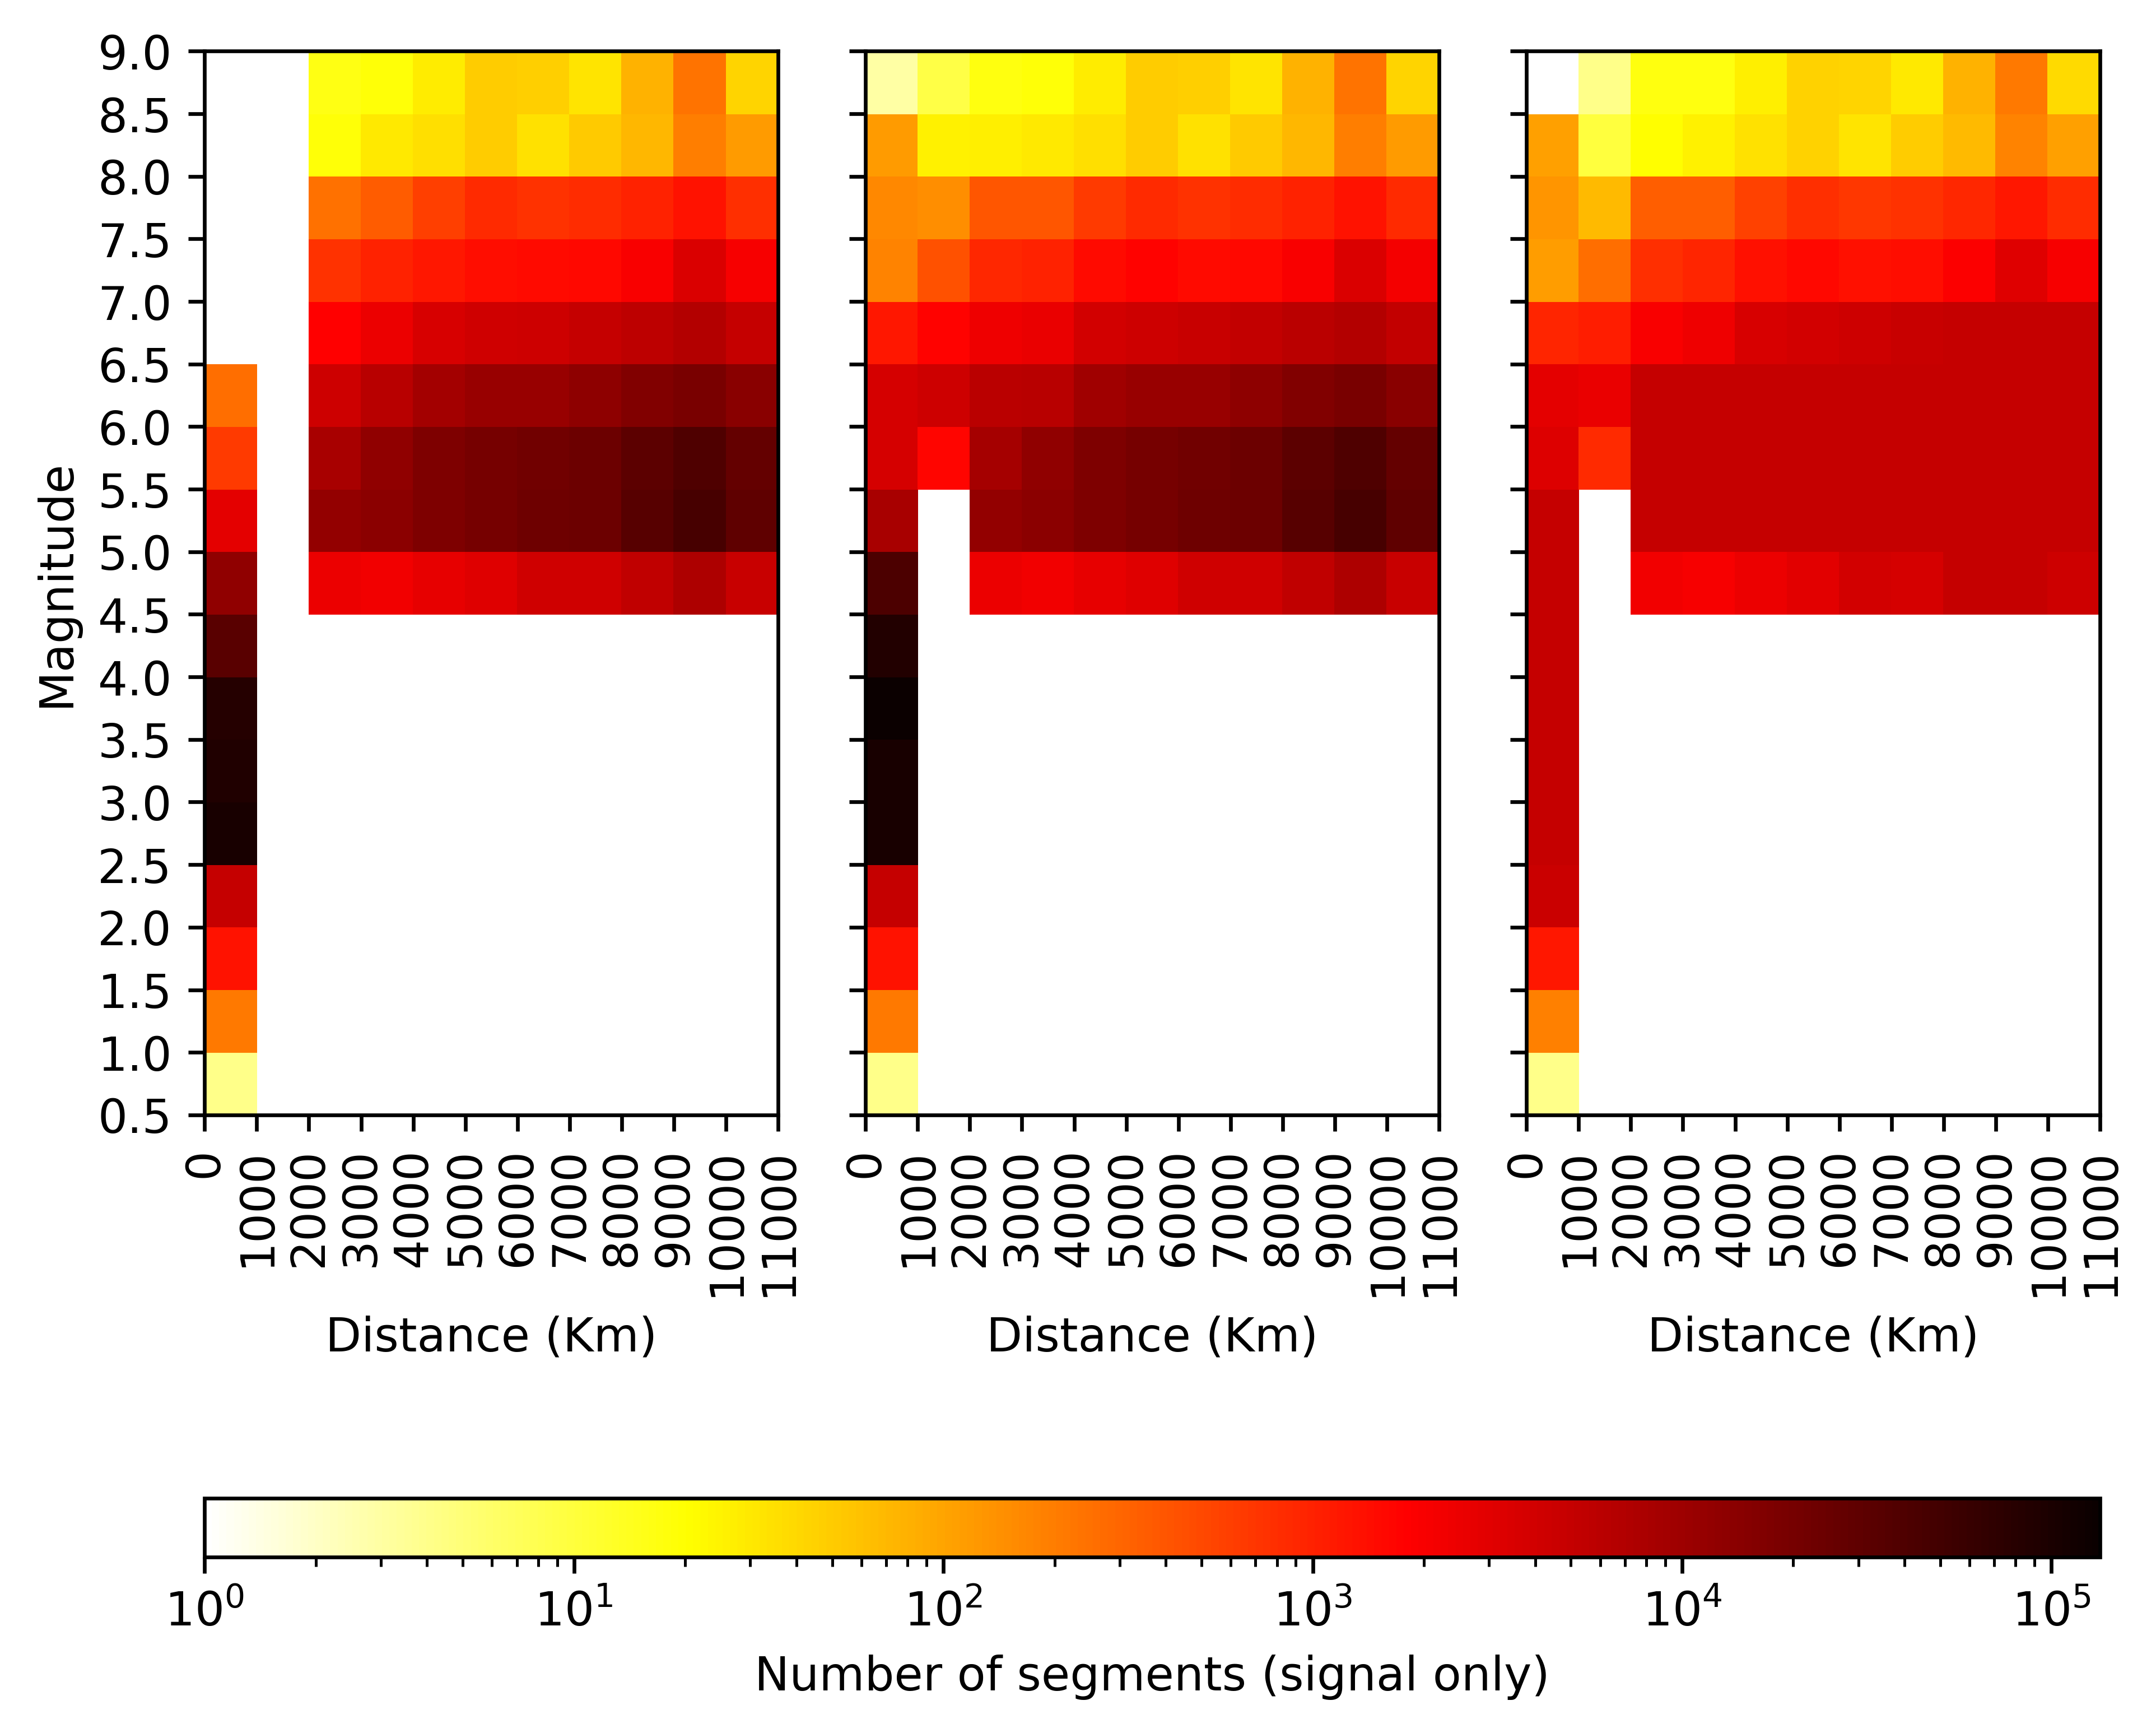

In [90]:
printhtml(f'<h3>Plotting mag/dist segments distribution (inliers only, signal only)</h3>')

heatmap_dfs = [ # store our dataframes of signals only here for the heatmap (we will plot it later)
    pd.concat([LBL_DF[1], LBL_DF[2]]),
    pd.concat([LBL_DF[1], LBL_DF[2], LBL_DF[3], LBL_DF[4]]),
    LBL_DF['trainingset']
]

# now take only the inliers (because we are handling the trining set) and the signals only:
for i in range(len(heatmap_dfs)):
    heatmap_dfs[i] = heatmap_dfs[i][(~heatmap_dfs[i].outlier) & heatmap_dfs[i].window_type]


heatmap_xname, heatmap_yname = 'distance_km', 'magnitude'
heatmap_xrange, hetmap_yrange = np.arange(0, 12000, 1000), np.arange(0.5, 9.5, 0.5)

# re arrange the (yet-to-be) heatmaps:
# heatmap_dfs[2] = heatmap_dfs[1]
# heatmap_dfs[1] = pd.concat([heatmap_dfs[0], heatmap_dfs[1][heatmap_dfs[1].dataset_id == 4]], axis=0, ignore_index=True)
# heatmap_dfs[0] = heatmap_dfs[0][heatmap_dfs[0].dataset_id <= 2]
# and now build the real heatmaps:
heatmap_dfs = [heatmap_df(_, heatmap_xname, heatmap_yname, heatmap_xrange, hetmap_yrange)
              for _ in heatmap_dfs]
    
# plot heatmaps:
min_, max_ = np.inf, -np.inf
for hmap_df in heatmap_dfs:
    if hmap_df.min().min() < min_:
        min_ = hmap_df.min().min()
    if hmap_df.max().max() > max_:
        max_ = hmap_df.max().max()

print(f'min/max segments per cell: {min_}, {max_}')

cmap='hot_r'
norm = matplotlib.colors.LogNorm(vmin=1, vmax=max_, clip=True)  # max_, clip=True)


with rcparams(figsizeratio=(None, 0.8)):

    fig = plt.figure(constrained_layout=True)
    gsp = fig.add_gridspec(3, len(distributions), height_ratios=[.9, .05, .05])

    for i, hmap_df in enumerate(heatmap_dfs):

        axs = fig.add_subplot(gsp[0, i])
        axs.pcolor(hmap_df, cmap=cmap, norm=norm)  # cmap='cubehelix_r')  #

        # heatmap_df.index are pandas Interval. Take the laft of every interval
        # (plus the right of the last interval)
        yticks = [_.left for _ in hmap_df.index] + [hmap_df.index[-1].right]
        # set xticks as integers 0, 1...
        axs.set_yticks(range(len(yticks))) 
            
        if i == 0:
            # set xticks labels simply as str(ticks):
            axs.set_yticklabels([str(_) for _ in yticks])
            # axs.set_yticklabels(hmap_df.index)
            axs.set_ylabel(heatmap_yname.title().replace('_', ' '))
        else:
            axs.set_yticklabels([])
        
        # heatmap_df.columns are pandas Interval. Take the laft of every interval
        # (plus the right of the last interval)
        xticks = [_.left for _ in hmap_df.columns] + [hmap_df.columns[-1].right]
        # set xticks as integers 0, 1...
        axs.set_xticks(range(len(xticks))) 
        # set xticks labels simply as str(ticks):
        axs.set_xticklabels([str(_) for _ in xticks])
        
        axs.set_xlabel(heatmap_xname.title().replace('_', ' (') + ')')
        axs.xaxis.set_tick_params(rotation=90)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    axs = fig.add_subplot(gsp[2, :])
    cbar = plt.colorbar(sm, cax=axs, orientation='horizontal')  # , pad=1, shrink=0.5, use_gridspec=True)  #, ticks=np.linspace(0,2,N), )
    cbar.ax.set_xlabel('Number of segments (signal only)')
    plt.show()

    # savefig(fig, join(FIGURES_DESTDIR, 'outlierspaper-img001.pdf')

# clean stuff:
del heatmap_dfs

In [91]:
fpath = join(FIGURES_DESTDIR, f"outlierspaper-img001.{FIG_DEFAULT_EXT}")
print(fpath)
savefig(fig, fpath)

/Users/rizac/work/gfz/projects/sources/python/sdaas_eval/tmp/outlierspaper-img001.jpg


Saving figure to "/Users/rizac/work/gfz/projects/sources/python/sdaas_eval/tmp/outlierspaper-img001.jpg"

dpi: 300.0 width: 6.30 height: 6.30)

True

In [5]:
printhtml('<h3>Loading evaluation dataframe</h3>')
eval_df = read_eval_df('evaluationmetrics.hdf') #  read_summary_eval_df()

for setname in [TESTSETNAME_U, TESTSETNAME_12]:
    print()
    printhtml('<h4>Testset: "%s". Best models under "average precision score" (APS)</h4>' % setname)
    display(eval_df[eval_df.relative_filepath.str.endswith(os.sep + setname)].
            sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

Loading evaluation dataframe

Testset: "uniform_test.hdf". Best models under "average precision score" (APS)

clf       feats  n_estimators  max_samples  random_state  \
1607  IsolationForest    psd@5sec            50          512            25   
1605  IsolationForest    psd@5sec           100          512            25   
1594  IsolationForest    psd@5sec           100         1024            25   
1592  IsolationForest    psd@5sec           100         1024            11   
1104  IsolationForest    psd@5sec           100         1024            42   
1604  IsolationForest    psd@5sec           100          512            11   
1105  IsolationForest    psd@5sec            50         1024            42   
1598  IsolationForest    psd@5sec            50         2048            25   
1597  IsolationForest    psd@5sec           100         2048            25   
1599  IsolationForest    psd@5sec            50         2048            11   
1596  IsolationForest    psd@5sec           100         2048            11   
1108  IsolationForest    psd@5sec           100         4096            42   
...               ...         ...           ...          ...           ...   
869   IsolationForest  psd@0.2sec           100          512            42   
865   IsolationForest  psd@0.2sec            50         1024            42   
1119  IsolationForest  psd@0.2sec           100         2048            25   
1121  IsolationForest  psd@0.2sec           100          512            25   
868   IsolationForest  psd@0.2sec            50         2048            42   
1116  IsolationForest  psd@0.2sec            50         2048            25   
1127  IsolationForest  psd@0.2sec            50          512            25   
1124  IsolationForest  psd@0.2sec            50          512            11   
1123  IsolationForest  psd@0.2sec           100          512            11   
867   IsolationForest  psd@0.2sec           100         4096            42   
871   IsolationForest  psd@0.2sec            50          512            42   
870   IsolationForest  psd@0.2sec            50         4096            42   

      average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
1607                 0.971079          0.730038       0.976689  0.590869   
1605                 0.970786          0.741438       0.976366  0.597247   
1594                 0.970586          0.752108       0.975150  0.581386   
1592                 0.970564          0.739007       0.975348  0.577372   
1104                 0.970494          0.745727       0.975156  0.574587   
1604                 0.970490          0.743559       0.975866  0.604658   
1105                 0.970405          0.737435       0.975189  0.579604   
1598                 0.970360          0.716539       0.974505  0.560193   
1597                 0.970295          0.714902       0.974611  0.563666   
1599                 0.970213          0.737760       0.975100  0.559445   
1596                 0.970131          0.723908       0.974888  0.559709   
1108                 0.969981          0.711557       0.974598  0.553642   
...                       ...               ...            ...       ...   
869                  0.855109          0.655469       0.821767  0.613291   
865                  0.854566          0.638100       0.820186  0.604366   
1119                 0.853966          0.613300       0.818424  0.595315   
1121                 0.853853          0.657679       0.820008  0.624884   
868                  0.853706          0.606085       0.816929  0.595987   
1116                 0.853247          0.611825       0.818258  0.599531   
1127                 0.853157          0.658884       0.821454  0.621054   
1124                 0.852889          0.652996       0.821981  0.613006   
1123                 0.852112          0.656910       0.820241  0.621271   
867                  0.851992          0.580529       0.816429  0.583615   
871                  0.850421          0.663526       0.819174  0.623989   
870                  0.846766          0.602894       0.808122  0.593260   

            

Testset: "allset_test_AND_allset_unlabelled_annotation2.hdf". Best models under "average precision score" (APS)

clf                                             feats  \
830  IsolationForest                                          psd@5sec   
842  IsolationForest                                          psd@5sec   
843  IsolationForest                                          psd@5sec   
833  IsolationForest                                          psd@5sec   
841  IsolationForest                                          psd@5sec   
840  IsolationForest                                          psd@5sec   
828  IsolationForest                                          psd@5sec   
831  IsolationForest                                          psd@5sec   
858  IsolationForest                                          psd@5sec   
834  IsolationForest                                          psd@5sec   
839  IsolationForest                                          psd@5sec   
855  IsolationForest                                          psd@5sec   
..               ...                                               ...   
145  IsolationForest           psd@0.2sec,psd@0.5sec,psd@2sec,psd@5sec   
259  IsolationForest             psd@0.2sec,psd@1sec,psd@2sec,psd@5sec   
793  IsolationForest                                 psd@2sec,psd@5sec   
476  IsolationForest             psd@0.5sec,psd@1sec,psd@2sec,psd@5sec   
469  IsolationForest             psd@0.5sec,psd@1sec,psd@2sec,psd@5sec   
799  IsolationForest                                 psd@2sec,psd@5sec   
44   IsolationForest  psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec   
41   IsolationForest  psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec   
43   IsolationForest  psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec   
151  IsolationForest           psd@0.2sec,psd@0.5sec,psd@2sec,psd@5sec   
36   IsolationForest  psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec   
475  IsolationForest             psd@0.5sec,psd@1sec,psd@2sec,psd@5sec   

     n_estimators  max_samples  random_state  average_precision_score  \
830           100         2048            42                 0.970866   
842           200         4096            25                 0.970687   
843            50         4096            11                 0.970605   
833           200         2048            42                 0.970577   
841           200         4096            42                 0.970573   
840           200         4096            11                 0.970509   
828           100         2048            11                 0.970464   
831           200         2048            11                 0.970408   
858           200         8192            11                 0.970393   
834            50         2048            11                 0.970364   
839           100         4096            42                 0.970362   
855           100         8192            11                 0.970347   
..            ...          ...           ...                      ...   
145           100          512            25                 0.905497   
259            50          512            42                 0.905178   
793           100          512            25                 0.905169   
476            50          512            42                 0.903082   
469           100          512            25                 0.900261   
799            50          512            25                 0.900196   
44             50          512            42                 0.899932   
41            200          512            25                 0.899563   
43             50          512            25                 0.899393   
151            50          512            25                 0.894600   
36            100          512            25                 0.894249   
475            50          512            25                 0.888240   

     best_th_pr_curve  roc_auc_score  log_loss  \
830          0.746330       0.974132  0.606184   
842          0.718142       0.974026  0.588646   
843          0.726551       0.974377  0.587


(SAVE_FIGURES=False)


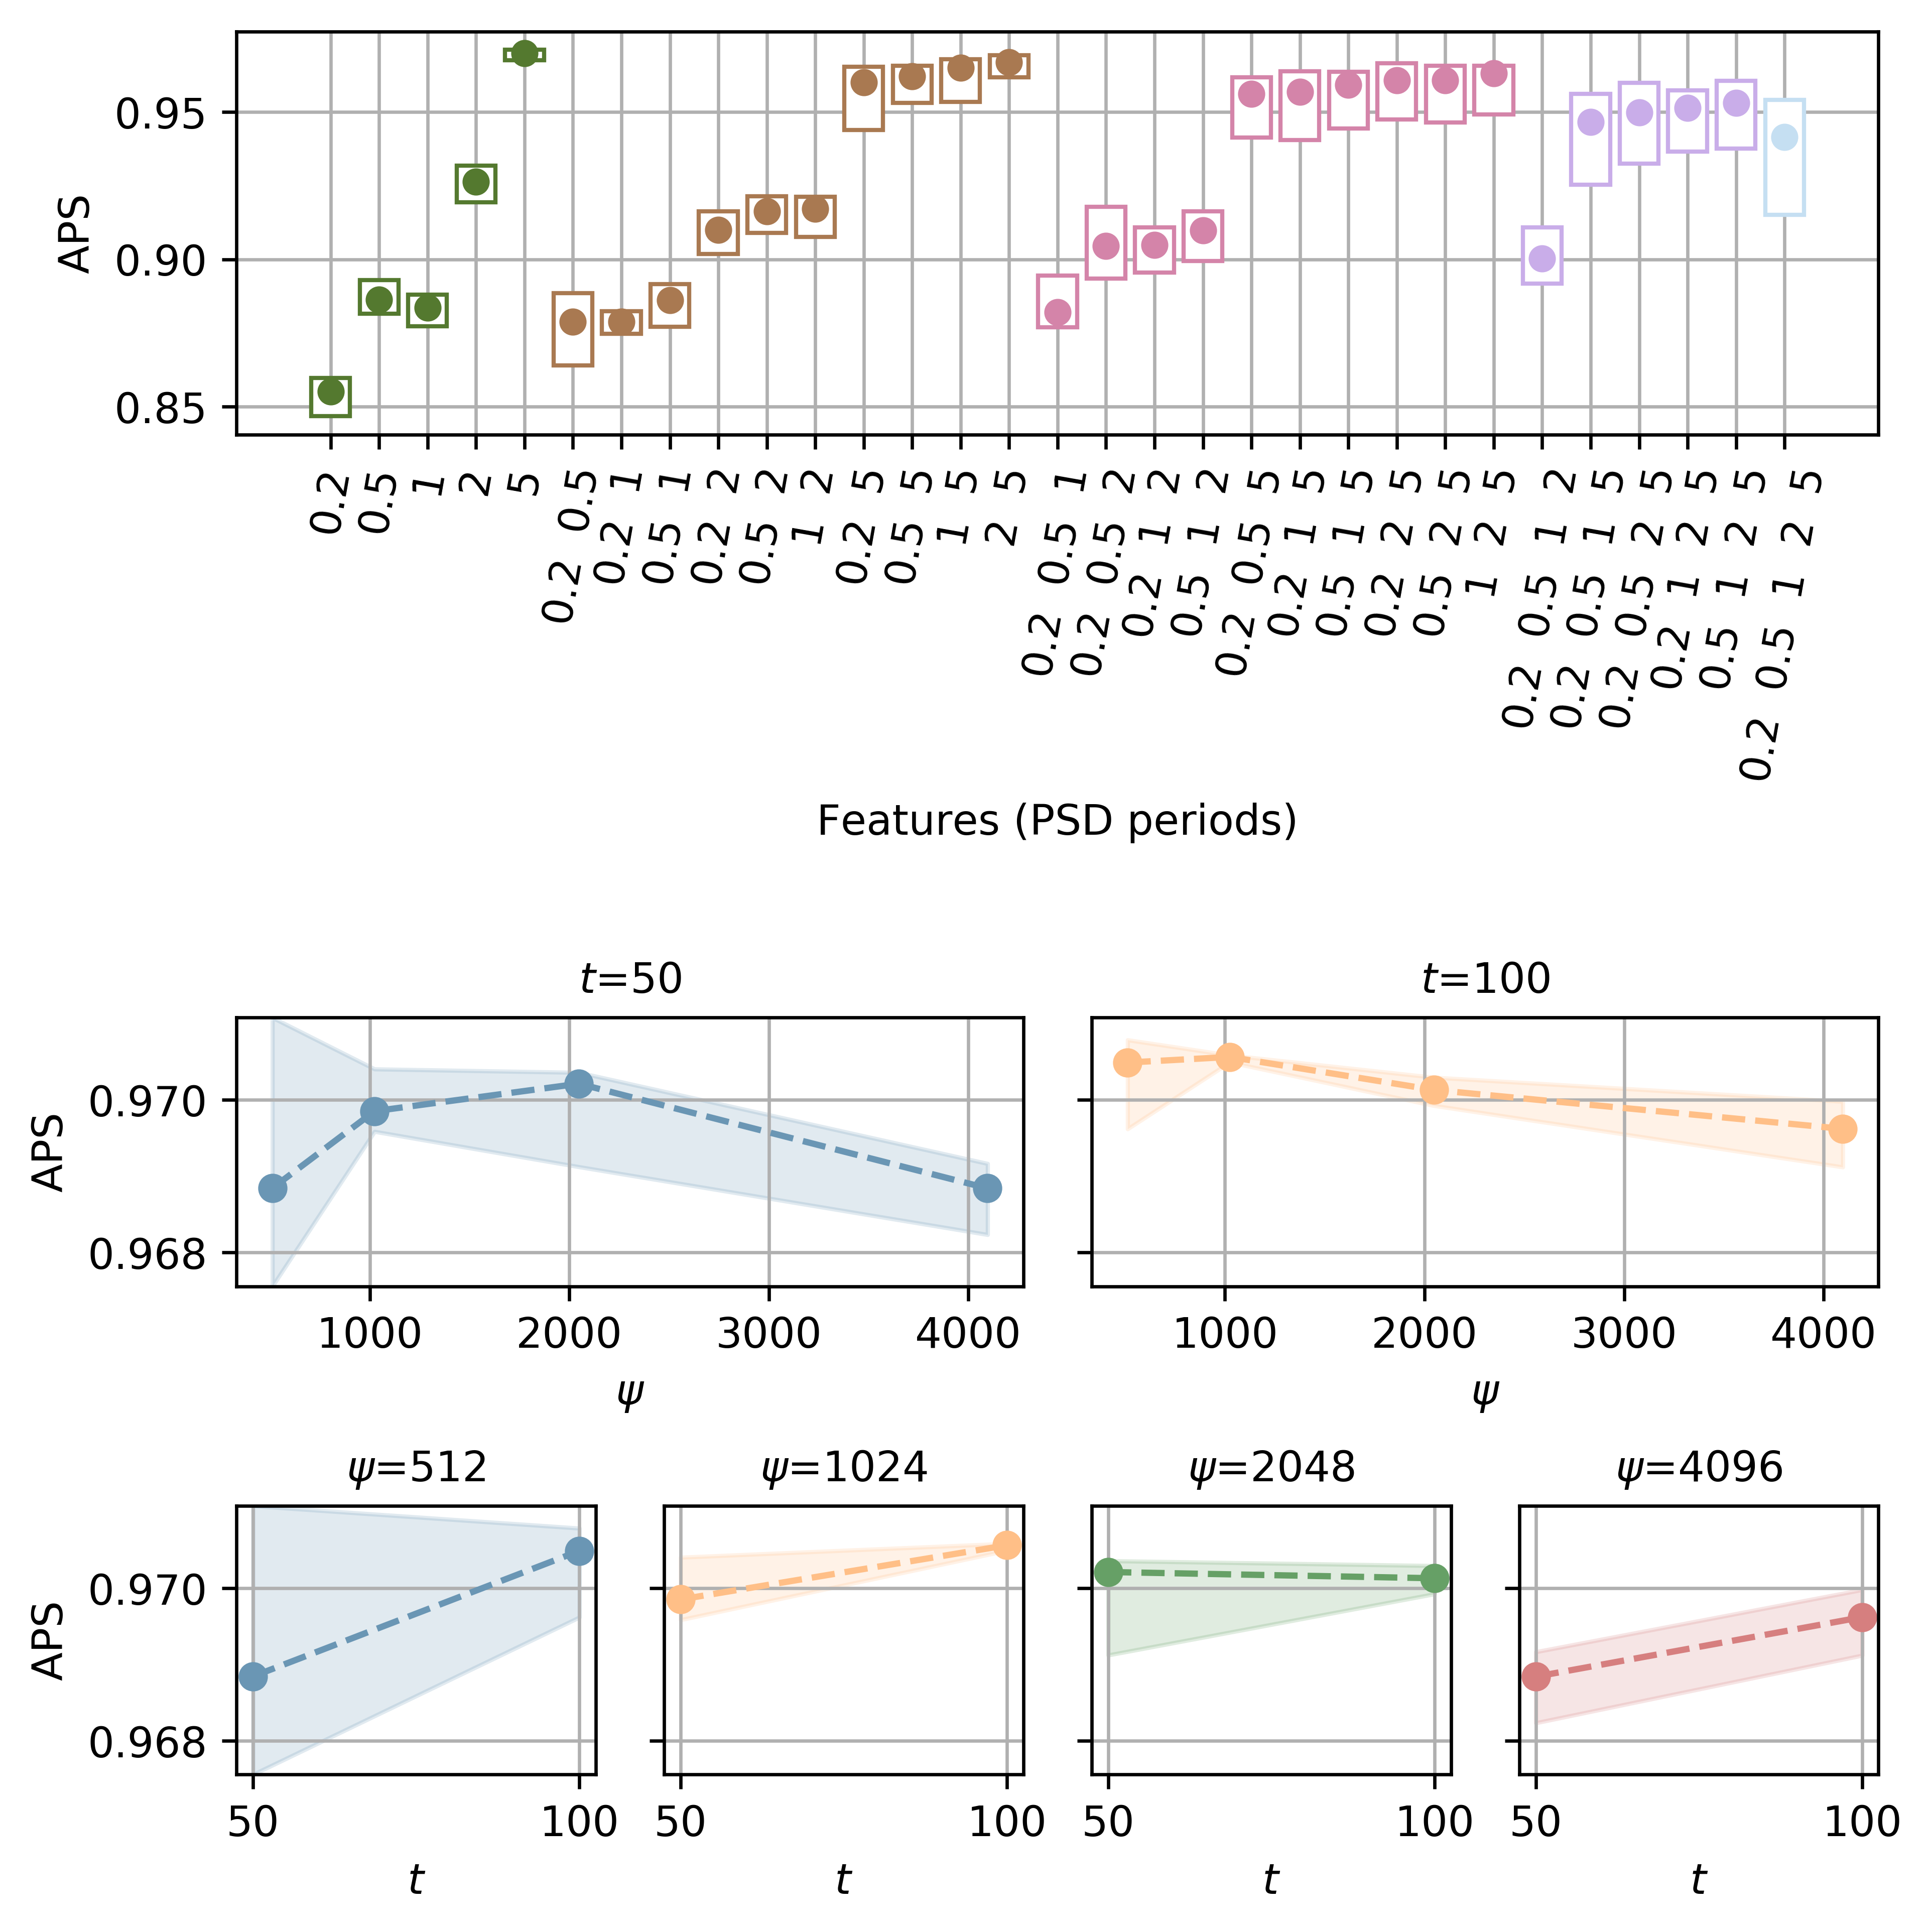

In [6]:
# sets = [(TESTSETNAME1, 'feats_and_hp_testset1'), (TESTSETNAME2, 'feats_and_hp_testset2')]
sets = [(TESTSETNAME_U, 'testset_uniform')]  #, (TESTSETNAME2, 'feats_and_hp_testset2')]

SCORE = 'average_precision_score'
score_label = 'APS'
# ne, ms = [50, 100, 200], [512, 1024, 2048, 4096, 8192, 16384]
ne, ms = [50, 100], [512, 1024, 2048, 4096]


for setname, filename in sets:
    print()
    fig = plt.figure(constrained_layout=True)
    gsp = fig.add_gridspec(4, max(len(ne), len(ms)), height_ratios=[9, 1, 6, 6])
    eval_df_ = eval_df[eval_df.relative_filepath.str.endswith(os.sep + setname)]
    axs = fig.add_subplot(gsp[0, :])
    plot_feats_vs_evalmetrics(eval_df_, [SCORE], ylabel=lambda metric: score_label, show=[axs])

    eval_df_ = eval_df_[eval_df_.feats.str.match('psd@5sec')]  # eval_df_[eval_df_.feats.str.contains('psd@5sec')]
    # eval_df_ = eval_df_[eval_df_.feats == 'psd@5sec']
    dfmin, dfmedian, dfmax = get_hyperparam_dfs(eval_df_, SCORE, n_estimators=ne, max_samples=ms)
    # rename columns for the plot: psi instead of max_samples, t instead of n_estimators
    # print(dfmin.columns.values)
    dfmin.columns.set_levels(['$\\psi$'],level=0,inplace=True)
    dfmin.index.set_levels(['$t$'],level=0,inplace=True)
    # print(dfmin.columns.values)
    

    axs = [fig.add_subplot(gsp[2, 2*i: 2*i+2]) for i in range(len(ne))]
    plot_hyperparam_dfs(dfmin, dfmedian, dfmax, ylabel=score_label, show=axs)

    axs = [fig.add_subplot(gsp[3, i]) for i in range(len(ms))]
    plot_hyperparam_dfs(dfmin.T, dfmedian.T, dfmax.T, ylabel=score_label, show=axs)

    savefig(fig, filename)

Plotting best models in details. All metrics computed on test set "uniform_test.hdf"

Grouping models by (n_estimators, max_samples) and keeping those with median average precision score

clf     feats  n_estimators  max_samples  random_state  \
1592  IsolationForest  psd@5sec           100         1024            11   
1604  IsolationForest  psd@5sec           100          512            11   
1599  IsolationForest  psd@5sec            50         2048            11   
1596  IsolationForest  psd@5sec           100         2048            11   
1595  IsolationForest  psd@5sec            50         1024            25   
1602  IsolationForest  psd@5sec           100         4096            25   
1606  IsolationForest  psd@5sec            50          512            11   
1601  IsolationForest  psd@5sec            50         4096            11   

      average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
1592                 0.970564          0.739007       0.975348  0.577372   
1604                 0.970490          0.743559       0.975866  0.604658   
1599                 0.970213          0.737760       0.975100  0.559445   
1596                 0.970131          0.723908       0.974888  0.559709   
1595                 0.969853          0.739561       0.975201  0.574039   
1602                 0.969622          0.680671       0.974166  0.556366   
1606                 0.968845          0.745870       0.975527  0.605512   
1601                 0.968842          0.668166       0.973910  0.556683   

                                                                                                                                                    relative_filepath  
1592  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
1604   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1599   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf  
1596  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
1595   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf  
1602  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf  
1606    clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf  
1601   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf

Defining plot function and plotting

Plotting detailed model predictions with n_estimators=100

[●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●] 100.0% 0:00:00

(SAVE_FIGURES=False)


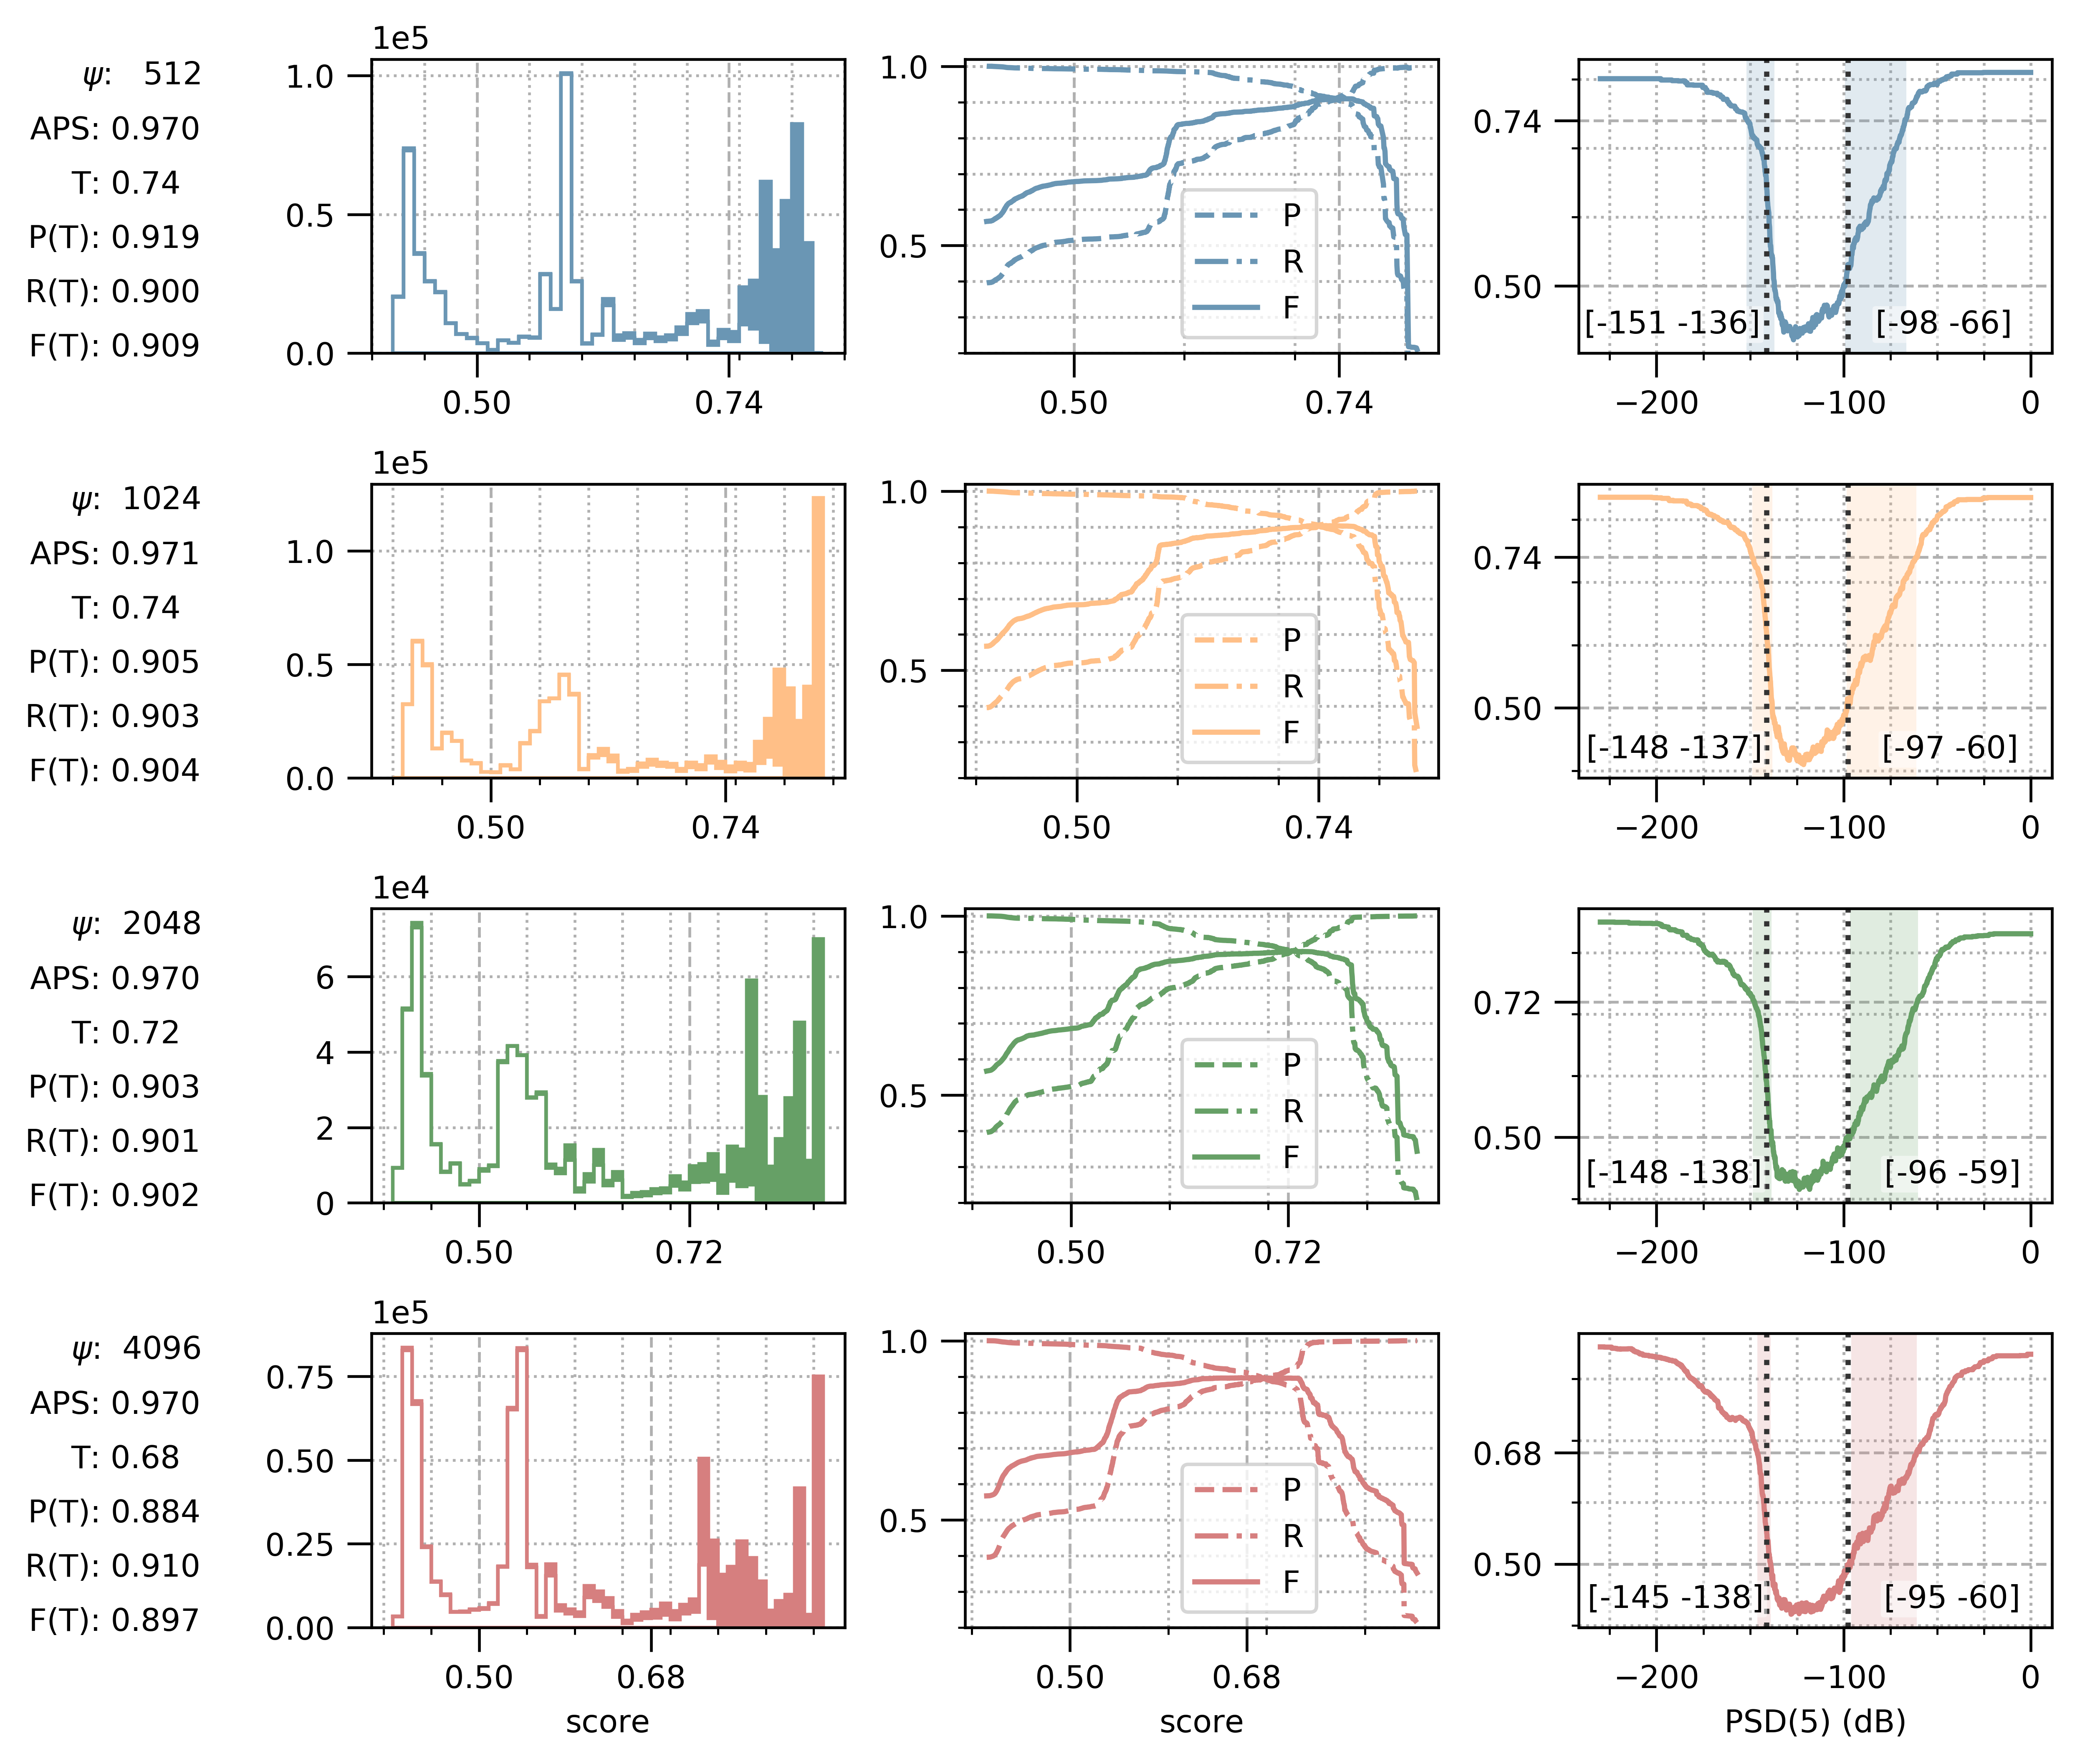

Plotting detailed model predictions with n_estimators=50

[●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●] 100.0% 0:00:00

(SAVE_FIGURES=False)


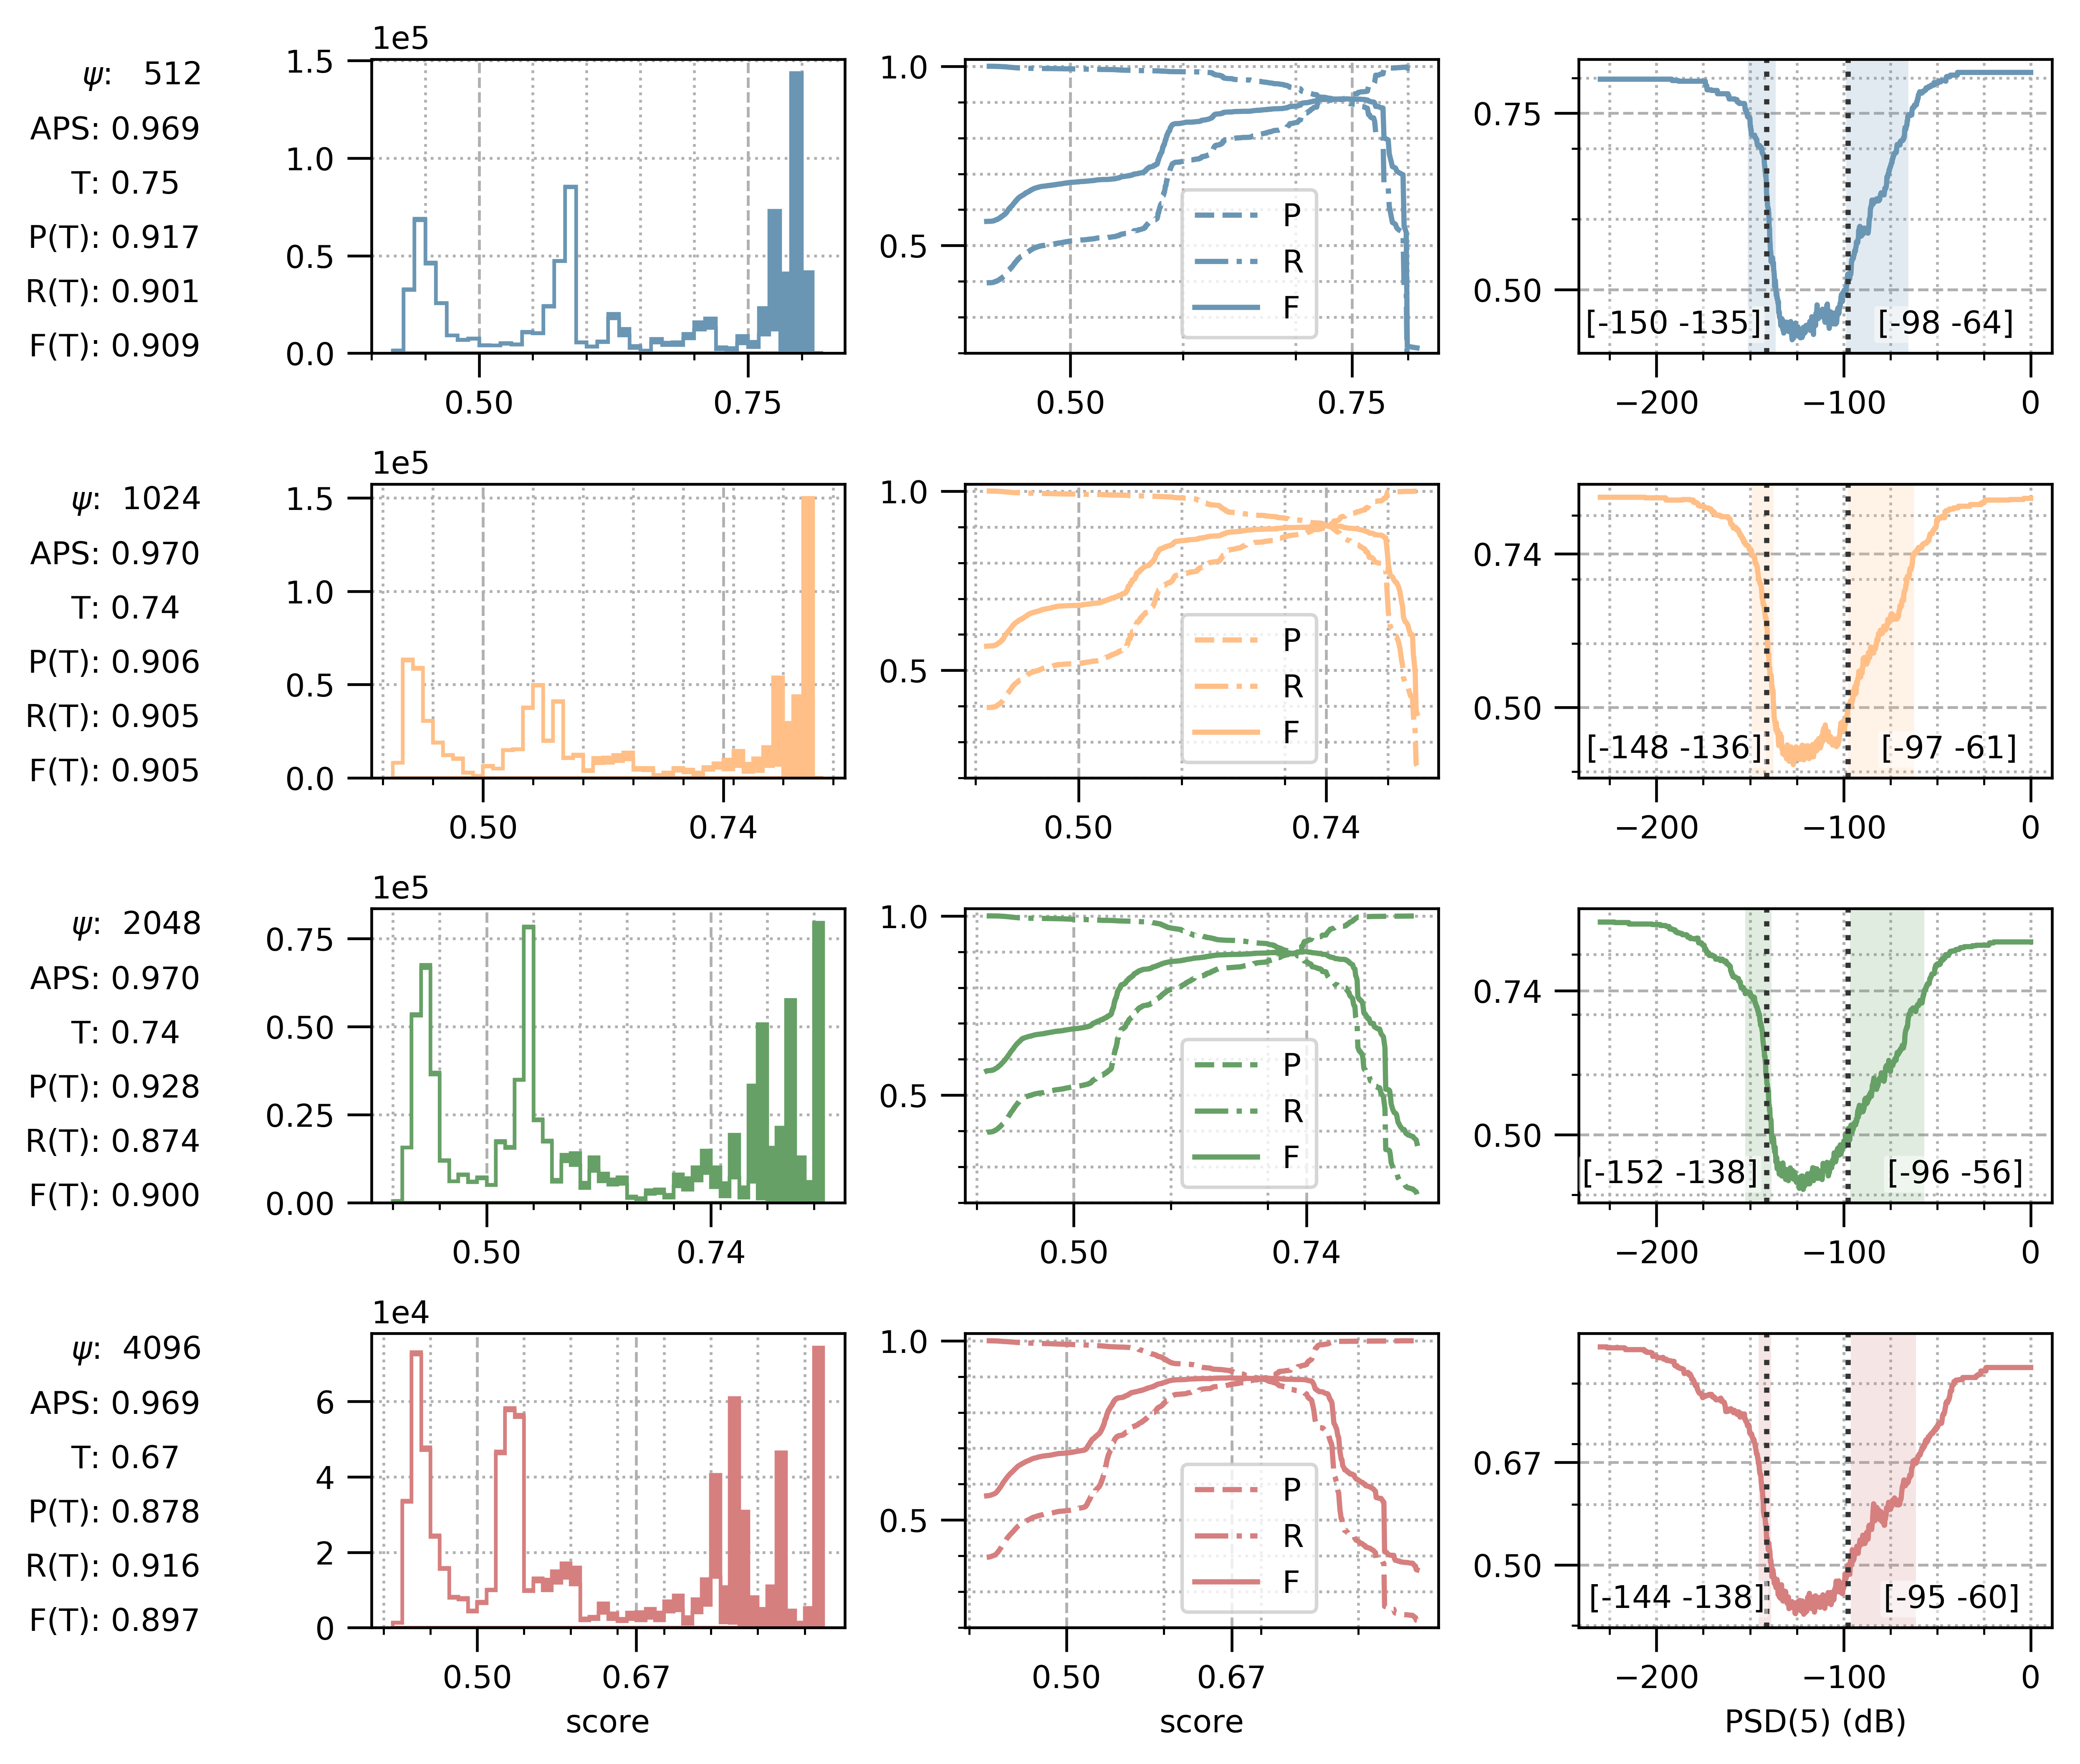

In [50]:
setname = TESTSETNAME_U

printhtml('<h3>Plotting best models in details. All metrics computed on test set "%s"</h3>' % setname)


printhtml('<h4>Grouping models by (n_estimators, max_samples) and keeping those with median '
          'average precision score</h4>')

eval_df2 = []
for _, _df in eval_df[(eval_df.feats == 'psd@5sec') &
                      (eval_df.relative_filepath.str.endswith(os.sep + setname))].\
        groupby(['n_estimators', 'max_samples']):
    _df = _df[_df.average_precision_score == _df.average_precision_score.median()]
    # _df = _df[_df.random_state == 11]
    assert len(_df) == 1
    eval_df2.append(_df)
    # eval_df2.append(_df.sort_values('average_precision_score')[1:2])  # median
eval_df2 = pd.concat(eval_df2, axis=0, sort=False)

pd.set_option('display.max_rows', 500)
# display(eval_df.sort_values(['average_precision_score'], ascending=False).head(30))
display(eval_df2.sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])



printhtml('<h4>Defining plot function and plotting</h4>')

def plot_prediction_per_maxsamples(pred_dfs):
    
    from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)

    # printhtml('<h3>Summary plots n_estimators=200 only (and random_state=11)</h3>')

    PETTERSON_PERIOD = 5  # set to 0 to ignore

    rows, cols = len(pred_dfs), 4
    # rows, cols = 2*len(pred_dfs), 3
    fig = plt.figure(constrained_layout=True)
    gsp = fig.add_gridspec(rows, cols, width_ratios=[1,10, 10, 10])
    # gsp = fig.add_gridspec(rows, cols, height_ratios=[1,15] * len(pred_dfs))
    colors = get_colors(len(pd.unique([_.max_samples for _ in pred_dfs.keys()])))
    psdperiods = np.arange(-230, 0, 0.1)

    # axs_all = [[], [], []]
    for idx, (rowtuple, pred_df) in enumerate(pred_dfs.items()):
        title= "(max_s=%s)" % (rowtuple.max_samples)

        # SEGMENTS DISTRIBUTION PLOT
        aps, p, r, th, f = EVALMETRICS.computeall(pred_df, EVALMETRICS.APS,
                                                  EVALMETRICS.PMAX, EVALMETRICS.RMAX,
                                                  EVALMETRICS.BEST_TH_PR, EVALMETRICS.F1MAX)

        axs = fig.add_subplot(gsp[idx, 1])
        mpl_hist_args = {
            'color': ['white', colors[idx]],
            'edgecolor':colors[idx],
            'histtype': 'stepfilled', 'stacked': True,
            # 'linewidth': 2
        }
        axs = plot_freq_distribution(pred_df, axs, title='', mpl_hist_args=mpl_hist_args)
        axs.set_xticks([0.5, np.round(th, 2)])
        axs.tick_params(which='major', length=7)
        axs.grid(axis="both", which='both', linestyle=':')
        axs.grid(axis="x", which='major', linestyle='--')
        axs.set_axisbelow(True)
        if idx < len(pred_dfs) - 1:
            axs.set_xlabel('')
        axs.set_ylabel('')

        # P, R, F PLOT
        axs = fig.add_subplot(gsp[idx, 2])
        axs = plot_pre_rec_fscore(pred_df, axs, title='', mpl_plot_args={'color': colors[idx]})
        axs.tick_params(which='major', length=7)
        axs.grid(axis="both", which='both', linestyle=':')
        axs.grid(axis="x", which='major', linestyle='--')
        # get the labels and replace them:
        old_legend = f'\nT: {axs.get_lines()[0].get_label()[2:6]:}  '  # <- last space for alignmenet (see plots)
        for line in axs.get_lines():
            old_legend += f'\n{line.get_label()[:2]}T{line.get_label()[6:]}'.replace('=', ': ')
            line.set_label(line.get_label()[:1])  # P, R , F
        # bbox_to_anchor: A 2-tuple (x, y) places the corner of the legend specified by `loc` at x, y. 
        lgnd = axs.legend(loc='lower center', bbox_to_anchor=(0.6, 0),
                          # handletextpad=0.1, #handlelength=1 # https://stackoverflow.com/a/49689249
                         )  
        axs.set_ylim(0.2, 1.02)
        axs.set_axisbelow(True)
        if idx < len(pred_dfs) - 1:
            axs.set_xlabel('')
        axs.set_ylabel('')

        # SCORE VS PSD PLOT
        axs = fig.add_subplot(gsp[idx, 3])
        clf = load_clf(dirname(rowtuple.relative_filepath) + '.sklmodel')
        scores = -clf.score_samples(psdperiods.reshape(len(psdperiods), 1))
        # plot scores:
        axs.plot(psdperiods, scores, color=colors[idx])  # , linewidth=2)
        # plot petterson:
        pbounds = get_petterson_bounds(PETTERSON_PERIOD)
        axs.axvline(pbounds[0], linestyle=':', color=[.2, .2, .2])  # , linewidth=2)
        axs.axvline(pbounds[1], linestyle=':', color=[.2, .2, .2])  # , linewidth=2)
        # plot shaded areas between 0.5 and score optimizing f1score:
        indices1 = argwhere_array_equals_value(scores, th)
        indices2 = argwhere_array_equals_value(scores, 0.5)
        psd_l = psdperiods[indices1[0]], psdperiods[indices2[0]]
        axs.axvspan(psd_l[0], psd_l[1], alpha=0.2, linestyle='--', linewidth=0, color=colors[idx])
        psd_h = psdperiods[indices2[-1]], psdperiods[indices1[-1]]
        axs.axvspan(psd_h[0], psd_h[1], alpha=0.2, linestyle='--', linewidth=0, color=colors[idx])
        # displaying bounds:
        bound1 = str([int(psd_l[0]+0.5), int(psd_l[1]+0.5)]).replace(',', '')
        bound2 = str([int(psd_h[0]+0.5), int(psd_h[1]+0.5)]).replace(',', '')
        w1 = float(psd_l[1] - psd_l[0])
        w2 = float(psd_h[1] - psd_h[0])
        # we use bbox argument of axs.text to have more control over the oputput. Some abbreviations:
        # are: fc (facecolor), ec (edgecolor), lw=0 (actually, with lw=0 below we invalidate ec)
        bboxargs = dict(boxstyle='round,pad=0.1', fc=[1,1,1,0.5], ec=plt.rcParams['legend.edgecolor'], lw=0)
        axs.text(psd_l[1] - w1/2.0, min(scores), bound1, ha='right', va='bottom', backgroundcolor=[1,1,1,0.5],
                bbox=bboxargs)
        axs.text(psd_h[0] + w2/2.0, min(scores), bound2, ha='left', va='bottom', backgroundcolor=[1,1,1,0.5],
                bbox=bboxargs)
        # set axis ticks:
        axs.xaxis.set_minor_locator(MultipleLocator(25))
        axs.yaxis.set_minor_locator(MultipleLocator(0.1))
        axs.grid(axis="both", which='both', linestyle=':')
        axs.grid(axis="y", which='major', linestyle='--')
        axs.set_yticks([0.5, np.round(th, 2)])
        axs.tick_params(which='major', length=7)
        if idx == len(pred_dfs) - 1:
            axs.set_xlabel('PSD(5) (dB)')
        # axs.set_ylabel('score')
        axs.set_axisbelow(True)

        # summary in the leftmost plot:
        # plot it as last so we have all data avilable
        axs = fig.add_subplot(gsp[idx, 0])
        text = f'$\psi$: {rowtuple.max_samples:>5d}\nAPS: {aps:.3f}' # % (rowtuple.max_samples, aps)
        text += old_legend
        axs.text(0.5, 1, text, ha='right', va='top', rotation=0, linespacing=2)  # , family='monospace') 
        axs.set_axis_off()

    return fig

_f = plt.rcParams['font.size'] * .9
with rcparams({'font.size': _f, 'axes.titlesize': _f}, figsizeratio=(1.3, 1.1)):  #  {'font.size': 12}, hratio=.9):  # {'figure.figsize'] = (14, 16), plt.rcParams['font.size'] = 14
    for nest in [100, 50]:  # [50, 100, 200]:
        print()
        printhtml('<h4>Plotting detailed model predictions with n_estimators=%d</h4>' % nest)
        pred_dfs = get_pred_dfs(eval_df2[eval_df2.n_estimators == nest], columns=['predicted_anomaly_score', 'window_type', 'outlier', 'dataset_id'])
        # for _ in list(pred_dfs):
        #    pred_dfs[_] = pred_dfs[_][(pred_dfs[_].dataset_id==1) & ((pred_dfs[_].window_type))]
        fig = plot_prediction_per_maxsamples(pred_dfs)
        savefig(fig, 'feat5sec_allperfs_nest=%d' % nest)
        plt.show()

In [8]:
setname = TESTSETNAME_U
feats = 'psd@5sec'

for n_est in (50, 100):
    printhtml(f'<h3>Performances on {setname}, features={feats}, n_estimators={n_est}</h3>')


    # printhtml('<h4>Grouping models by (n_estimators, max_samples) and keeping those with median '
    #           'average precision score</h3>')

    eval_df2 = []
    for _, _df in eval_df[(eval_df.feats == 'psd@5sec') & (eval_df.n_estimators == n_est) &
                          (eval_df.relative_filepath.str.endswith(os.sep + setname))].\
            groupby(['n_estimators', 'max_samples']):
        _df = _df[_df.average_precision_score == _df.average_precision_score.median()]
        assert len(_df) == 1
        eval_df2.append(_df)
    eval_df2 = pd.concat(eval_df2, axis=0, sort=False)

    pd.set_option('display.max_rows', 500)

    display(eval_df2.sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

    printhtml(f'Loading {len(eval_df2)} prediction dataframes to compute intra metrics')
    pred_dfs = get_pred_dfs(eval_df2, columns=['predicted_anomaly_score',
                                               'channel_code',
                                               'station_id', 'Segment.db.id', 'outlier',
                                               'location_code', 'window_type', 'dataset_id', 'magnitude'])

    from collections import defaultdict
    metricname = 'average_precision_score'


    hls = read_handlabelled_segments()

    misclcount = []

    for did in [1, 2, 3, 4]:
        for wtype in (True, False):
            wtype_str = 'SIGNAL' if wtype else 'NOISE'
            print()
            print()
            # printhtml(f'<h4>Performances on {setname}, features={feats}, n_estimators={n_est}</h4>')
            printhtml(f'<h4>Performances on {wtype_str} windows only, dataset_id={did}</h4>')
            partial_eval = defaultdict(list)
            miscl_outl = defaultdict(list)
            miscldf = None
            for k, (tupl, p) in enumerate(pred_dfs.items()):
                _p = p[(p.dataset_id == did) & (p.window_type == wtype)]

                # caluclate misclassified outliers:
                _m = _p
                _m = _m[_m.outlier & (_m.predicted_anomaly_score < tupl.best_th_pr_curve)].copy()
                misclcount.append(len(_m))
                _m['_KEY'] = (_m.station_id).astype('str').str.cat(_m.location_code, sep='.').str.cat(_m.channel_code.str[:-1], sep='.') + '?'
                for key, _df in _m.groupby('_KEY'):
                    miscl_outl[key].append(len(_df))

                # calculate metric on partial evaluation set:
                aps = EVALMETRICS.APS.compute(_p)
                partial_eval[metricname] += [aps]
                for fld in tupl._fields:
                    if fld != metricname:
                        partial_eval[fld] += [getattr(tupl, fld)]

            # display new evaluation dataframe (partial set):
            display(pd.DataFrame(partial_eval).sort_values([metricname], ascending=False)[EVALDF_DISPLAYCOLUMNS])

            # display misclassified oiutliers and stations of interest:
            _dic = {k: np.mean(v) for k, v in miscl_outl.items() if len(v) == len(pred_dfs)}
            _dic = pd.DataFrame(_dic.values(), columns=['MOs (average count)'], index=_dic.keys()).\
                sort_values(['MOs (average count)'], ascending=False)
            _n = 5
            printhtml(f'We have an average of {np.mean(misclcount):,.2f} misclassified outliers (MO) per model '
                  f'(MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the {_n} "most wrong" channels (ignoring orientation):')
            # printhtml(f'Details grouping by channels (ignoring orientation) and showing first {_n} only')
            _dicprint = _dic.head(_n)
            _dicprint = _dicprint.append(_dicprint.sum(numeric_only=True).rename('Total'))
            display(_dicprint)


    #print()
    #printhtml(f'<h3>Details on feats={miscltup.feats}, n_estimators={miscltup.n_estimators}, max_samples={miscltup.max_samples}, random_state={miscltup.random_state}</h3>')
    #printhtml(f'<h4>{len(miscldf)} of {misclcount} outliers ar "kind of" misclassified, i.e. have scores < {miscltup.best_th_pr_curve}</h4>')
    #print('Unique segment ids (whihc have both noise and signal misclassified):')
    #miscldf = miscldf.sort_values('predicted_anomaly_score', ascending=True)
    #display(" ".join(str(_[1]['Segment.db.id'].iloc[0]) for _ in miscldf.groupby('Segment.db.id', sort=False) if len(_[1]) == 2))
    #print()
    #print('Dataframe:')
    #display(miscldf)

    # for _ in eval_df.itertuples():
    #     pred_df = get_pred_df
    # display(eval_df2.sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

Performances on uniform_test.hdf, features=psd@5sec, n_estimators=50

clf     feats  n_estimators  max_samples  random_state  \
1599  IsolationForest  psd@5sec            50         2048            11   
1595  IsolationForest  psd@5sec            50         1024            25   
1606  IsolationForest  psd@5sec            50          512            11   
1601  IsolationForest  psd@5sec            50         4096            11   

      average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
1599                 0.970213          0.737760       0.975100  0.559445   
1595                 0.969853          0.739561       0.975201  0.574039   
1606                 0.968845          0.745870       0.975527  0.605512   
1601                 0.968842          0.668166       0.973910  0.556683   

                                                                                                                                                   relative_filepath  
1599  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf  
1595  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf  
1606   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf  
1601  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf

Loading 4 prediction dataframes to compute intra metrics

[●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●] 100.0% 0:00:00

Performances on SIGNAL windows only, dataset_id=1

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec            50          512            11   
2  IsolationForest  psd@5sec            50         2048            11   
1  IsolationForest  psd@5sec            50         1024            25   
3  IsolationForest  psd@5sec            50         4096            11   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                 0.895322          0.745870       0.975527  0.605512   
2                 0.884585          0.737760       0.975100  0.559445   
1                 0.883995          0.739561       0.975201  0.574039   
3                 0.875973          0.668166       0.973910  0.556683   

                                                                                                                                                relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf

We have an average of 10,925.00 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
3791..HH?              2265.75
7744..HH?              1645.25
7704..HH?              1539.75
5600..HN?              1455.50
7673..HH?               838.00
Total                  7744.25

Performances on NOISE windows only, dataset_id=1

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec            50          512            11   
2  IsolationForest  psd@5sec            50         2048            11   
1  IsolationForest  psd@5sec            50         1024            25   
3  IsolationForest  psd@5sec            50         4096            11   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                 0.885596          0.745870       0.975527  0.605512   
2                 0.874070          0.737760       0.975100  0.559445   
1                 0.872897          0.739561       0.975201  0.574039   
3                 0.868633          0.668166       0.973910  0.556683   

                                                                                                                                                relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf

We have an average of 10,709.75 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
3791..HH?              1856.25
7744..HH?              1628.25
7704..HH?              1527.50
5600..HN?              1453.00
7673..HH?               858.00
Total                  7323.00

Performances on SIGNAL windows only, dataset_id=2

clf     feats  n_estimators  max_samples  random_state  \
3  IsolationForest  psd@5sec            50         4096            11   
1  IsolationForest  psd@5sec            50         1024            25   
2  IsolationForest  psd@5sec            50         2048            11   
0  IsolationForest  psd@5sec            50          512            11   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
3                 0.987935          0.668166       0.973910  0.556683   
1                 0.987871          0.739561       0.975201  0.574039   
2                 0.987742          0.737760       0.975100  0.559445   
0                 0.983975          0.745870       0.975527  0.605512   

                                                                                                                                                relative_filepath  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf

We have an average of 9,955.92 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
3507..BH?               785.00
2861..BH?               582.25
2863..BH?               480.00
2772..BH?               420.75
10..BH?                 225.00
Total                  2493.00

Performances on NOISE windows only, dataset_id=2

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec            50          512            11   
1  IsolationForest  psd@5sec            50         1024            25   
2  IsolationForest  psd@5sec            50         2048            11   
3  IsolationForest  psd@5sec            50         4096            11   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                 0.994345          0.745870       0.975527  0.605512   
1                 0.994297          0.739561       0.975201  0.574039   
2                 0.994252          0.737760       0.975100  0.559445   
3                 0.993947          0.668166       0.973910  0.556683   

                                                                                                                                                relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf

We have an average of 8,518.38 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
2772..BH?               954.75
3507..BH?               785.00
2861..BH?               625.50
2863..BH?               493.00
10..BH?                 244.75
Total                  3103.00

Performances on SIGNAL windows only, dataset_id=3

/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec            50          512            11   
1  IsolationForest  psd@5sec            50         1024            25   
2  IsolationForest  psd@5sec            50         2048            11   
3  IsolationForest  psd@5sec            50         4096            11   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                      NaN          0.745870       0.975527  0.605512   
1                      NaN          0.739561       0.975201  0.574039   
2                      NaN          0.737760       0.975100  0.559445   
3                      NaN          0.668166       0.973910  0.556683   

                                                                                                                                                relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf

We have an average of 6,814.70 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
Total                 NaN

Performances on NOISE windows only, dataset_id=3

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec            50          512            11   
1  IsolationForest  psd@5sec            50         1024            25   
2  IsolationForest  psd@5sec            50         2048            11   
3  IsolationForest  psd@5sec            50         4096            11   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                      NaN          0.745870       0.975527  0.605512   
1                      NaN          0.739561       0.975201  0.574039   
2                      NaN          0.737760       0.975100  0.559445   
3                      NaN          0.668166       0.973910  0.556683   

                                                                                                                                                relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf

We have an average of 5,678.92 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
Total                 NaN

Performances on SIGNAL windows only, dataset_id=4

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec            50          512            11   
1  IsolationForest  psd@5sec            50         1024            25   
2  IsolationForest  psd@5sec            50         2048            11   
3  IsolationForest  psd@5sec            50         4096            11   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                      1.0          0.745870       0.975527  0.605512   
1                      1.0          0.739561       0.975201  0.574039   
2                      1.0          0.737760       0.975100  0.559445   
3                      1.0          0.668166       0.973910  0.556683   

                                                                                                                                                relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf

We have an average of 4,867.64 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
Total                 NaN

Performances on NOISE windows only, dataset_id=4

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec            50          512            11   
1  IsolationForest  psd@5sec            50         1024            25   
2  IsolationForest  psd@5sec            50         2048            11   
3  IsolationForest  psd@5sec            50         4096            11   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                      1.0          0.745870       0.975527  0.605512   
1                      1.0          0.739561       0.975201  0.574039   
2                      1.0          0.737760       0.975100  0.559445   
3                      1.0          0.668166       0.973910  0.556683   

                                                                                                                                                relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf

We have an average of 4,259.19 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
Total                 NaN

Performances on uniform_test.hdf, features=psd@5sec, n_estimators=100

clf     feats  n_estimators  max_samples  random_state  \
1592  IsolationForest  psd@5sec           100         1024            11   
1604  IsolationForest  psd@5sec           100          512            11   
1596  IsolationForest  psd@5sec           100         2048            11   
1602  IsolationForest  psd@5sec           100         4096            25   

      average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
1592                 0.970564          0.739007       0.975348  0.577372   
1604                 0.970490          0.743559       0.975866  0.604658   
1596                 0.970131          0.723908       0.974888  0.559709   
1602                 0.969622          0.680671       0.974166  0.556366   

                                                                                                                                                    relative_filepath  
1592  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
1604   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1596  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
1602  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf

Loading 4 prediction dataframes to compute intra metrics

[●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●] 100.0% 0:00:00

Performances on SIGNAL windows only, dataset_id=1

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec           100          512            11   
1  IsolationForest  psd@5sec           100         1024            11   
2  IsolationForest  psd@5sec           100         2048            11   
3  IsolationForest  psd@5sec           100         4096            25   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                 0.900679          0.743559       0.975866  0.604658   
1                 0.888295          0.739007       0.975348  0.577372   
2                 0.886165          0.723908       0.974888  0.559709   
3                 0.884246          0.680671       0.974166  0.556366   

                                                                                                                                                 relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf

We have an average of 10,540.75 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
3791..HH?              2094.75
7744..HH?              1644.25
7704..HH?              1539.50
5600..HN?              1455.00
7673..HH?               833.75
Total                  7567.25

Performances on NOISE windows only, dataset_id=1

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec           100          512            11   
1  IsolationForest  psd@5sec           100         1024            11   
2  IsolationForest  psd@5sec           100         2048            11   
3  IsolationForest  psd@5sec           100         4096            25   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                 0.893483          0.743559       0.975866  0.604658   
1                 0.877535          0.739007       0.975348  0.577372   
2                 0.876241          0.723908       0.974888  0.559709   
3                 0.875873          0.680671       0.974166  0.556366   

                                                                                                                                                 relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf

We have an average of 10,333.25 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
3791..HH?              1654.25
7744..HH?              1629.75
7704..HH?              1520.75
5600..HN?              1452.50
7673..HH?               863.75
Total                  7121.00

Performances on SIGNAL windows only, dataset_id=2

clf     feats  n_estimators  max_samples  random_state  \
2  IsolationForest  psd@5sec           100         2048            11   
1  IsolationForest  psd@5sec           100         1024            11   
3  IsolationForest  psd@5sec           100         4096            25   
0  IsolationForest  psd@5sec           100          512            11   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
2                 0.987162          0.723908       0.974888  0.559709   
1                 0.987116          0.739007       0.975348  0.577372   
3                 0.986986          0.680671       0.974166  0.556366   
0                 0.982504          0.743559       0.975866  0.604658   

                                                                                                                                                 relative_filepath  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf

We have an average of 9,548.17 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
3507..BH?               785.00
2861..BH?               569.50
2863..BH?               453.50
2772..BH?               394.00
10..BH?                 224.25
Total                  2426.25

Performances on NOISE windows only, dataset_id=2

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec           100          512            11   
1  IsolationForest  psd@5sec           100         1024            11   
2  IsolationForest  psd@5sec           100         2048            11   
3  IsolationForest  psd@5sec           100         4096            25   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                 0.994874          0.743559       0.975866  0.604658   
1                 0.994527          0.739007       0.975348  0.577372   
2                 0.994375          0.723908       0.974888  0.559709   
3                 0.994053          0.680671       0.974166  0.556366   

                                                                                                                                                 relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf

We have an average of 8,152.44 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
2772..BH?               938.75
3507..BH?               785.00
2861..BH?               603.75
2863..BH?               479.50
10..BH?                 249.75
Total                  3056.75

Performances on SIGNAL windows only, dataset_id=3

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec           100          512            11   
1  IsolationForest  psd@5sec           100         1024            11   
2  IsolationForest  psd@5sec           100         2048            11   
3  IsolationForest  psd@5sec           100         4096            25   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                      NaN          0.743559       0.975866  0.604658   
1                      NaN          0.739007       0.975348  0.577372   
2                      NaN          0.723908       0.974888  0.559709   
3                      NaN          0.680671       0.974166  0.556366   

                                                                                                                                                 relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf

We have an average of 6,521.95 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
Total                 NaN

Performances on NOISE windows only, dataset_id=3

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec           100          512            11   
1  IsolationForest  psd@5sec           100         1024            11   
2  IsolationForest  psd@5sec           100         2048            11   
3  IsolationForest  psd@5sec           100         4096            25   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                      NaN          0.743559       0.975866  0.604658   
1                      NaN          0.739007       0.975348  0.577372   
2                      NaN          0.723908       0.974888  0.559709   
3                      NaN          0.680671       0.974166  0.556366   

                                                                                                                                                 relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf

We have an average of 5,434.96 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
Total                 NaN

Performances on SIGNAL windows only, dataset_id=4

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec           100          512            11   
1  IsolationForest  psd@5sec           100         1024            11   
2  IsolationForest  psd@5sec           100         2048            11   
3  IsolationForest  psd@5sec           100         4096            25   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                      1.0          0.743559       0.975866  0.604658   
1                      1.0          0.739007       0.975348  0.577372   
2                      1.0          0.723908       0.974888  0.559709   
3                      1.0          0.680671       0.974166  0.556366   

                                                                                                                                                 relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf

We have an average of 4,658.54 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
Total                 NaN

Performances on NOISE windows only, dataset_id=4

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec           100          512            11   
1  IsolationForest  psd@5sec           100         1024            11   
2  IsolationForest  psd@5sec           100         2048            11   
3  IsolationForest  psd@5sec           100         4096            25   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                      1.0          0.743559       0.975866  0.604658   
1                      1.0          0.739007       0.975348  0.577372   
2                      1.0          0.723908       0.974888  0.559709   
3                      1.0          0.680671       0.974166  0.556366   

                                                                                                                                                 relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf

We have an average of 4,076.22 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
Total                 NaN

Plotting some segments and their predicted score in details

Classifier used:

clf     feats  n_estimators  max_samples  random_state  \
1592  IsolationForest  psd@5sec           100         1024            11   

      average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
1592                 0.970564          0.739007       0.975348  0.577372   

     behaviour  best_th_roc_curve contamination  \
1592       new           0.731568          auto   

                                                                                                                                                    relative_filepath  \
1592  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf   

                 tr_set  
1592  uniform_train.hdf

IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=1024, n_estimators=100,
                n_jobs=None, random_state=11, verbose=0, warm_start=False)


Segment to plot:


Segment.db.id  dataset_id  station_id channel_code location_code  \
699819       17366761           1        4901          HNZ                 
699820       17366761           1        4901          HNZ                 

        window_type          event_time  outlier  magnitude  distance_km  \
699819        False 2016-10-30 06:48:27     True        3.8    44.146339   
699820         True 2016-10-30 06:48:27     True        3.8    44.146339   

        predicted_anomaly_score  
699819                 0.657044  
699820                 0.819866

0 segments of same channel found, median score: nan


Segment to plot:


Segment.db.id  dataset_id  station_id channel_code location_code  \
714098       17878897           1        7744          HHE                 
714099       17878897           1        7744          HHE                 

        window_type          event_time  outlier  magnitude  distance_km  \
714098        False 2016-10-26 21:52:52     True        3.7   305.597619   
714099         True 2016-10-26 21:52:52     True        3.7   305.597619   

        predicted_anomaly_score  
714098                 0.650591  
714099                 0.634552

0 segments of same channel found, median score: nan


Segment to plot:


Segment.db.id  dataset_id  station_id channel_code location_code  \
837566            828           2        1070          BHZ                 
837567            828           2        1070          BHZ                 

        window_type          event_time  outlier  magnitude  distance_km  \
837566        False 2019-08-29 15:07:59     True        6.3  9706.275946   
837567         True 2019-08-29 15:07:59     True        6.3  9706.275946   

        predicted_anomaly_score  
837566                 0.834844  
837567                 0.834844

5968 segments of same channel found, median score: 0.83


Segment to plot:


Segment.db.id  dataset_id  station_id channel_code location_code  \
775824         426081           2        1061          BHZ                 
775825         426081           2        1061          BHZ                 

        window_type          event_time  outlier  magnitude  distance_km  \
775824        False 2018-08-17 04:35:27     True        5.3  9078.856559   
775825         True 2018-08-17 04:35:27     True        5.3  9078.856559   

        predicted_anomaly_score  
775824                 0.824682  
775825                 0.829085

3572 segments of same channel found, median score: 0.83


Segment to plot:


Segment.db.id  dataset_id  station_id channel_code location_code  \
690929          10673           2        1061          BHZ                 
690930          10673           2        1061          BHZ                 

        window_type          event_time  outlier  magnitude  distance_km  \
690929        False 2019-08-10 03:41:21    False        5.4  5418.500428   
690930         True 2019-08-10 03:41:21    False        5.4  5418.500428   

        predicted_anomaly_score  
690929                 0.430821  
690930                 0.430826

3572 segments of same channel found, median score: 0.83


Segment to plot:


Segment.db.id  dataset_id  station_id channel_code location_code  \
646287           2058           2        1010          BHZ                 
646288           2058           2        1010          BHZ                 

        window_type          event_time  outlier  magnitude  distance_km  \
646287        False 2019-08-28 23:46:40    False        5.9  8902.942212   
646288         True 2019-08-28 23:46:40    False        5.9  8902.942212   

        predicted_anomaly_score  
646287                 0.789449  
646288                 0.766256

3292 segments of same channel found, median score: 0.78

(SAVE_FIGURES=False)


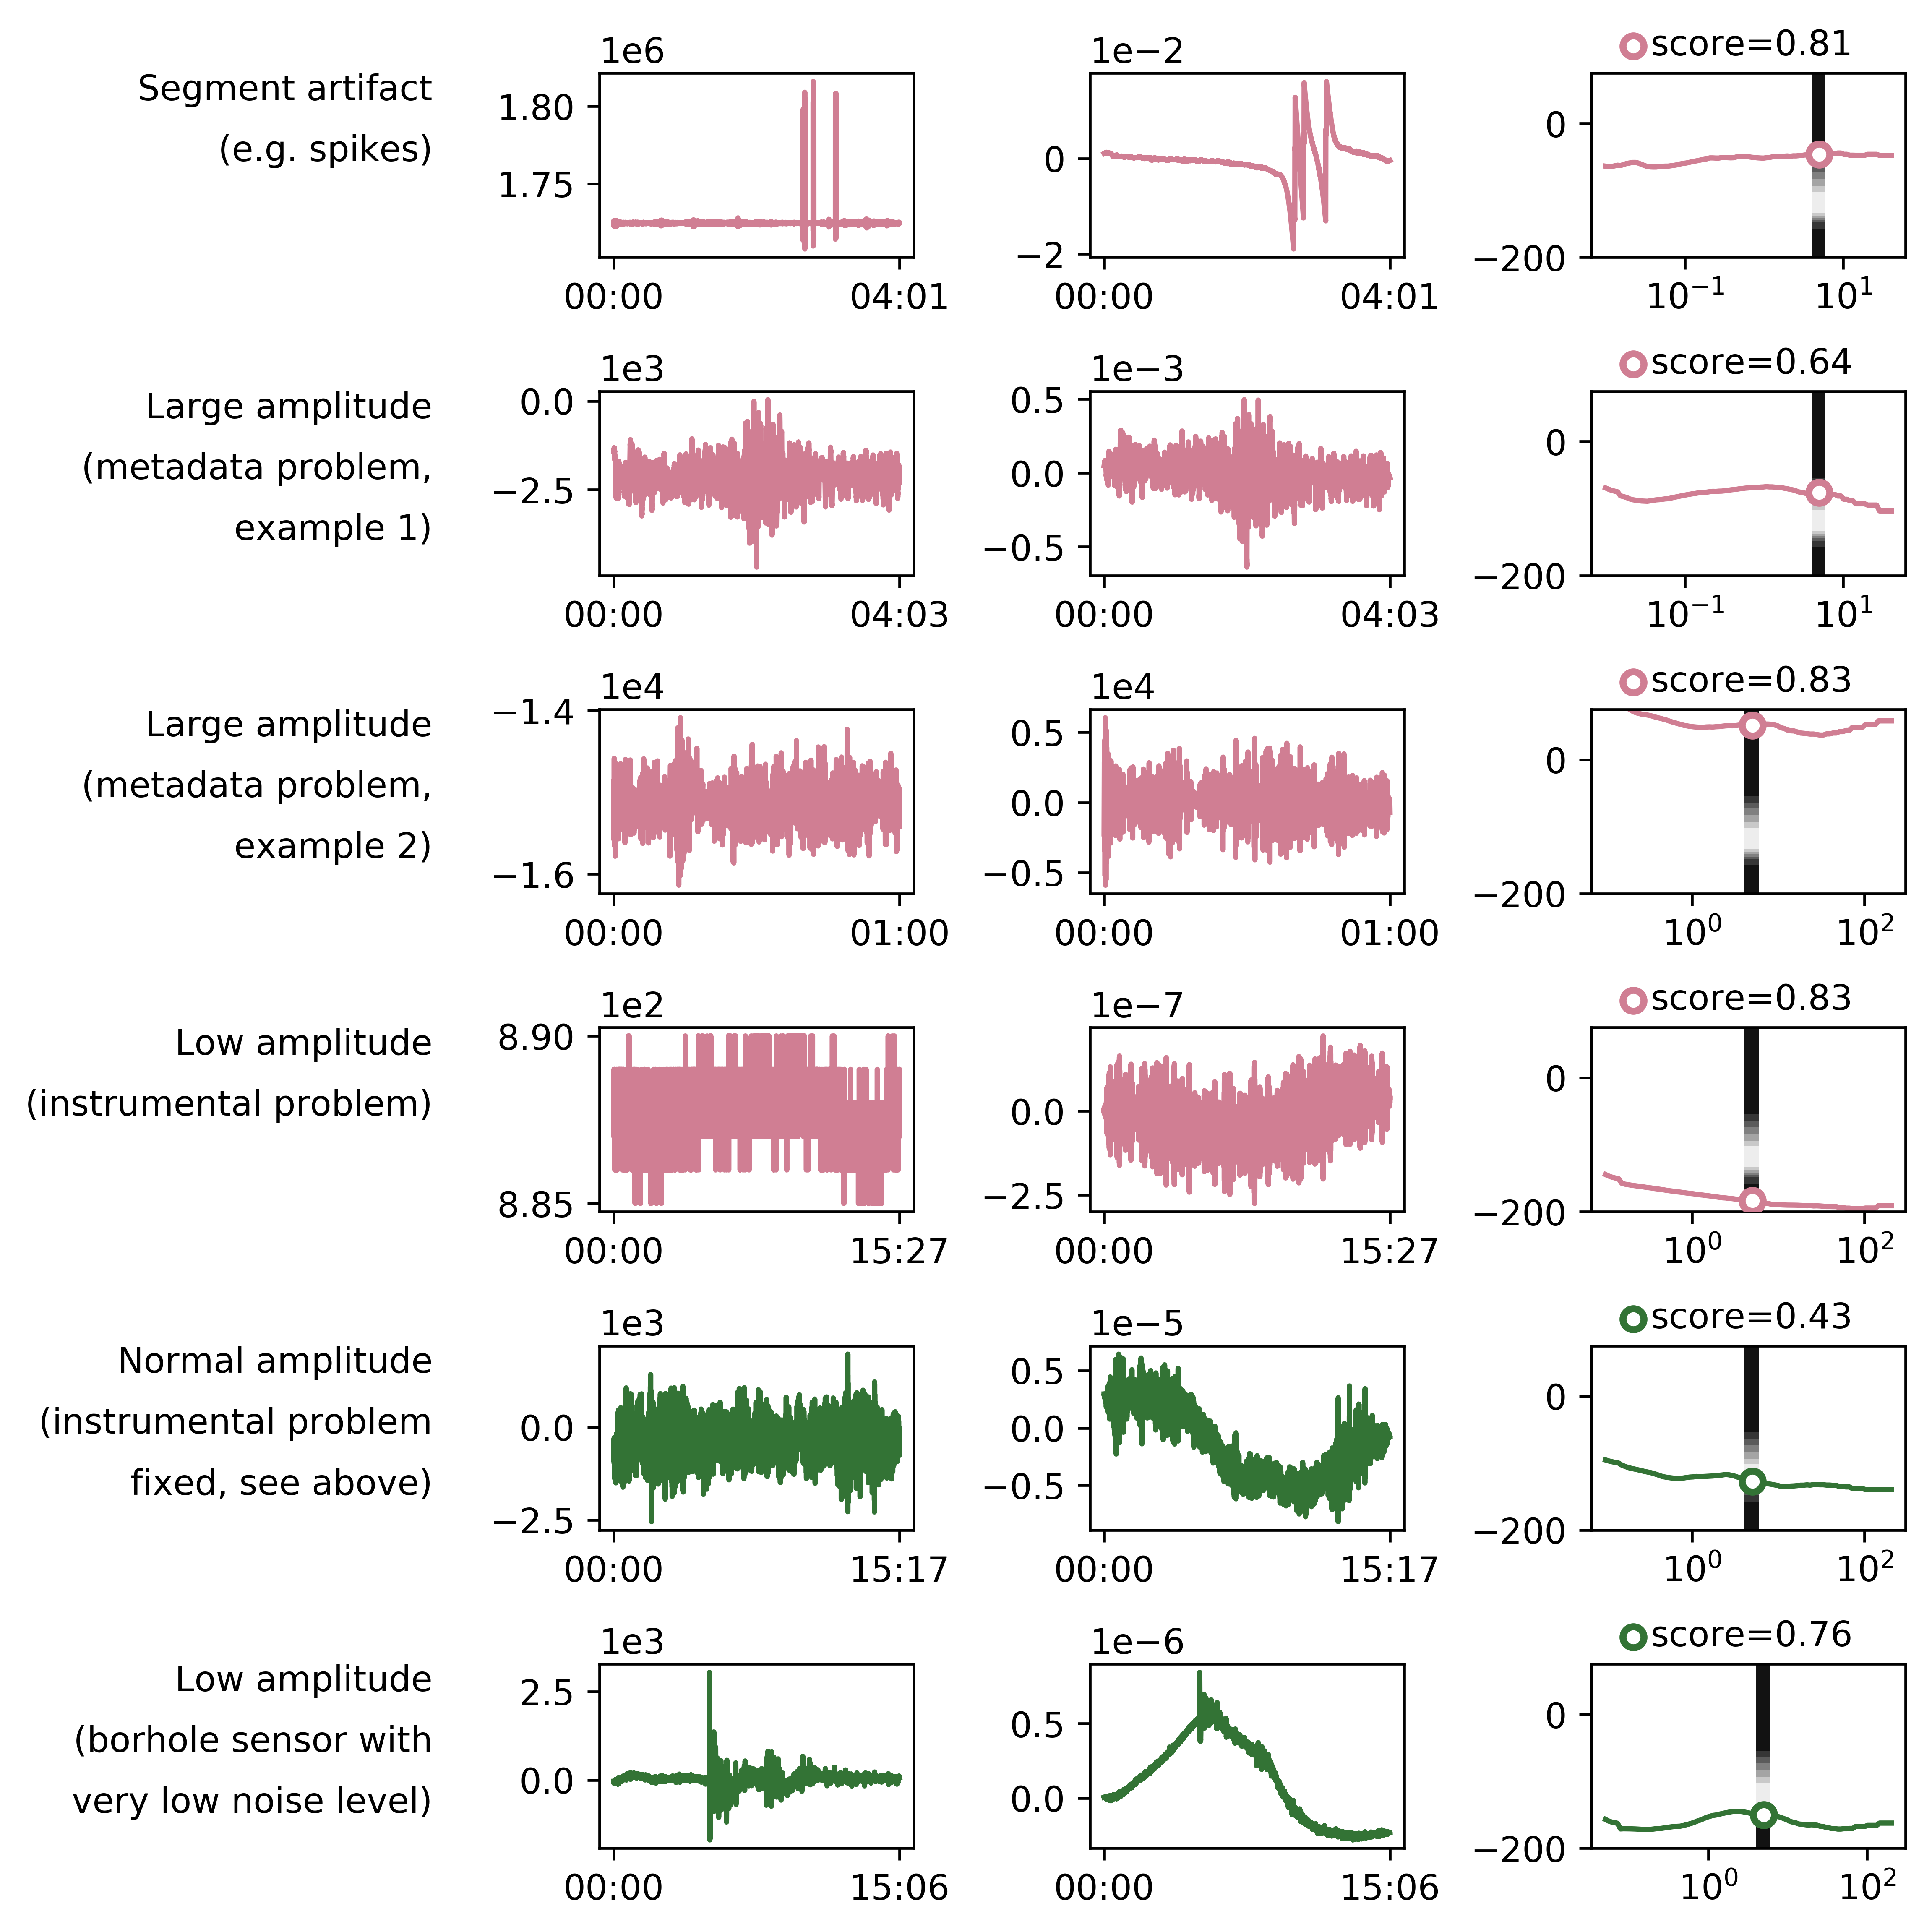

In [71]:
printhtml('<h3>Plotting some segments and their predicted score in details</h3>')

nest = 100
maxs = 1024  # 2048
setname = TESTSETNAME_U  # TESTSETNAME_12

# low and high ranges (in dB) of "undecided zone"
lpsd = [-152, -138]
hpsd = [-100, -66]
# ranges = [-152, -138], [-100, -66]

printhtml('<h4>Classifier used:</h4>')
eval_df3 = eval_df2[(eval_df2.n_estimators == nest) & (eval_df2.max_samples == maxs)]
display(eval_df3)
clf = load_clf(dirname(eval_df3.relative_filepath.iloc[0]) + '.sklmodel')
display(clf)
pred_df = read_pred_df(join(dirname(eval_df3.relative_filepath.iloc[0]), setname), columns=None)

def ppsd_2(segment, inventory):
    periods, amplitudes_db = ppsd(seg.stream()[0], seg.inventory())
    _, amplitude_db_5 = ppsd(seg.stream()[0], seg.inventory(), 5)
    return periods, amplitudes_db, amplitude_db_5


def plot_trace(axs, trace, inventory=None, **kwargs):
    from obspy import UTCDateTime
    # time0, dt = trace.stats.starttime, trace.stats.delta
    # times = [(time0 + dt*i).datetime for i in range(len(trace))]
    # trace = trace.trim(None, trace.stats.starttime+60)
    if inventory is not None:
        trace = trace.copy().remove_response(inventory)
    axs.plot(trace, **kwargs)
    axs.set_xticks([0, len(trace)-1])
    stime = UTCDateTime(int(np.round(float(trace.stats.starttime))))
    etime = UTCDateTime(int(np.round(float(trace.stats.endtime))))
    # would be nice if the first tick displayed the date also, something as: stime.isoformat().replace('T', ' ')
    # but then labels take too much room. So:
    tdl = timedelta(seconds=etime-stime)
    tdl_s = f'{(tdl.seconds // 60):02}:{(tdl.seconds % 60):02}'
    axs.set_xticklabels(['00:00', tdl_s])
    # ticklabel1 = stime.isoformat()[stime.isoformat().find('T')+1:]
    # ticklabel2 = etime.isoformat()[etime.isoformat().find('T')+1:]
    # axs.set_xticklabels([ticklabel1, ticklabel2])
    axs.ticklabel_format(axis='y', style='sci', scilimits=(-0,0))
    # axs.grid()


PSD_YLIM = (-200, 75)


def plot_psd(axs, trace, inventory, **kwargs):
    periods, amplitudes_db, amplitude_db_5 = ppsd_2(trace, inventory)
    # kwargs.setdefault('linewidth', 2)
    axs.semilogx(periods, amplitudes_db, **kwargs)
    
    LW = plt.rcParams['lines.linewidth']
#     LW3 = LW * 3
#     axs.axvline(5, color=[0., 0., 0.], linewidth=LW3)
#     axs.plot([5, 5], [lpsd[0], hpsd[1]], marker='None', color=[0.75, 0.75, 0.75], linewidth=LW3)
#     axs.plot([5, 5], [lpsd[1], hpsd[0]], marker='None', color=[1, 1, 1], linewidth=LW3)
    
    x_ = np.array([4,6])  # width of the score vertical line (defined by visual try and error)
    y_ = np.arange(-200, 100, 10)
    z_ = -clf.score_samples(y_.reshape(len(y_), 1))
    z_ = np.asarray([z_, z_]).T
    axs.contourf(x_, y_, z_, cmap='binary')
    
    clf_score = -clf.score_samples([[amplitude_db_5]])
    color = kwargs.get('color', 'black')
    axs.scatter(5, amplitude_db_5, marker='o', label='score=%.2f' % clf_score,
                color='white', edgecolor=color, zorder=100, linewidth=(LW*4.0)/3.0)
    # bbox_to_anchor: A 2-tuple (x, y) places the corner of the legend specified by `loc` at x, y.
    # If a 4-tuple or BboxBase is given, then it specifies the bbox (x, y, width, height)
    # example below taken from: https://matplotlib.org/3.2.1/tutorials/intermediate/legend_guide.html#legend-location
    # and modified with params listed in https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.legend.html#matplotlib.pyplot.legend
    axs.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', mode='expand', frameon=False,
               handletextpad=-0.5, borderpad=0.1, borderaxespad=0.1)  #, frameon=False)  # borderpad=0, 
    axs.set_ylim(*PSD_YLIM)
    #axs.grid()


def plotall(segment, row_idx, caption, trace=None, inv=None, preddf_segment_id=None):
    '''plots a row of plots. preddf_segment_id denotes the segment id stored
    in the prediction dataframe (for cases where segment id does not match the segment.id). If None,
    it defaults to segment.id'''
    if trace is None:
        trace = segment.stream()[0]
    if inv is None:
        inv = segment.inventory()
    # show the already computed scores for a double check:
    if preddf_segment_id is None:
        preddf_segment_id = seg.id
    seg_pred_df = pred_df[(pred_df['Segment.db.id'] == preddf_segment_id) & (pred_df.dataset_id == dataset_id)]
    print()
    print('Segment to plot:')
    display(seg_pred_df)
    # get all channel segments and print median score:
    scores = pred_df[(pred_df.station_id == seg.channel.station_id) & (pred_df.dataset_id == dataset_id) &
                     (pred_df.location_code == seg.channel.location) & (pred_df.channel_code == seg.channel.channel)].predicted_anomaly_score
    print('%d segments of same channel found, median score: %.2f' % (len(scores), scores.median()))
    print()
    # assert labelling is correct (just a check):
    outliers_count = seg_pred_df.outlier.sum() 
    assert outliers_count in (0, len(seg_pred_df))
    kwargs = {'color': colors[bool(outliers_count)]}
    # plot stuff:
    axs0 = fig.add_subplot(gsp[row_idx, 0])
    axs0.text(0.5, 1, caption, ha='right', va='top', rotation=0, linespacing=2,
              fontsize=plt.rcParams['axes.titlesize'])  # , family='monospace') 
    axs0.set_axis_off()
    axs1 = fig.add_subplot(gsp[row_idx, 1])
    plot_trace(axs1, trace, **kwargs)
    axs2 = fig.add_subplot(gsp[row_idx, 2])
    plot_trace(axs2, trace, inv, **kwargs)
    axs3 = fig.add_subplot(gsp[row_idx, 3])
    plot_psd(axs3, trace, inv, **kwargs)
    # if row_idx == 0:
    #    axs1.set_title('Trace')
    #    axs2.set_title('Trace (resp. removed)')
    #    axs3.set_title('PSD')
    
    allaxes = axs1, axs2, axs3
    # don't know why, but the gird appears on the LASt psd (??!)
    # turn grid off for all axes (set to True to turn it on):
    for _ in allaxes:
        _.grid(False, which='major', axis='both', linewidth=0)
    return allaxes



# PLOTTING:

with rcparams(figsizeratio=(1.2, 1.2)):

    fig = plt.figure(constrained_layout=True)
    gsp = fig.add_gridspec(6, 4, width_ratios=[1, 10, 10, 10])

    colors = get_colors(2, 0.35, 0.6)  # [::-1]


    # filter for the db query (common to all):
    flt = (Segment.has_data) & (Segment.maxgap_numsamples.between(-0.499, 0.499))

    psd_axes = []
    rowindex = -1

    # good station, segment is an outlier
    rowindex += 1
    dataset_id = 1
    with dbsession(dataset_id) as sess:
        # sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'IS.GEM' ) & Station.has_inventory)]
        # seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
        seg_id = 2781456 # in the old database was: 17366761  
        seg = sess.query(Segment).filter((Segment.id == seg_id) & flt).limit(1).one()
        _ = plotall(seg, rowindex, 'Segment artifact\n(e.g. spikes)', preddf_segment_id=17366761)
        psd_axes.append(_[-1])

    # Scale_units = nm/sec
    # they specify a good scale_units, but obspy's documentation asserts that they
    # assume units in m/sec (FIXME: citation?!!)
    rowindex += 1
    dataset_id = 1
    with dbsession(dataset_id) as sess:
        # old way (when we had the database 2019_03):
        # sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.network == 'SL' ) & Station.has_inventory)]
        # seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
        # seg_id = int(seg_ids.iloc[0]['Segment.db.id'])
        # new way:
        seg_id = 2675096
        seg = sess.query(Segment).filter((Segment.id == seg_id) & flt).limit(1).one()
        _ = plotall(seg, rowindex, 'Large amplitude\n(metadata problem,\nexample 1)', preddf_segment_id=17878897)
        psd_axes.append(_[-1])
        

    # Scale is big,  but scale units is ok, most likely metadata error.
    # We cannot say which is the cause, but the anomaly detector is good
    # (we suspect some mistake in the inventory)
    rowindex += 1
    dataset_id = 2
    with dbsession(dataset_id) as sess:
        sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.network == 'SJ' ) & Station.has_inventory)]
        seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
        # now select the fist:
        seg_id = int(seg_ids.iloc[0]['Segment.db.id'])
        seg = sess.query(Segment).filter((Segment.id == seg_id) & flt).limit(1).one()
        # in this case, display only noise otherwise it seems we
        # can classify only signals:
        tra = seg.stream()[0].copy().trim(None, seg.stream()[0].stats.starttime + 60)
        _ = plotall(seg, rowindex, 'Large amplitude\n(metadata problem,\nexample 2)', trace=tra)  
        psd_axes.append(_[-1])


    # # Metadata stage gain error
    # from obspy import read_inventory
    # inv = read_inventory(join(dirname(dirname(os.get_cwd())), 'stream2segment', 'inventories',
    #                           'CH.GRIMS.2015-10-30T10:50:00.xml'))
    # rowindex += 1
    # dataset_id = 1
    # with dbsession(dataset_id) as sess:
    #     sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'CH.GRIMS' ) & Station.has_inventory)]
    #     seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
    #     seg_ids = seg_ids['Segment.db.id'].tolist()
    #     seg = sess.query(Segment).join(Segment.event).filter(Segment.id.in_(seg_ids) & (Event.time < datetime(2016, 1, 1)) & flt).limit(1).one()
    #     _ = plotall(seg, rowindex, 'Metadata\nstage gain\nerror', inv=inv)
    #     psd_axes.append(_[-1])


    # # Metadata stage gain error
    # rowindex += 1
    # dataset_id = 1
    # with dbsession(dataset_id) as sess:
    #     sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'CH.GRIMS' ) & Station.has_inventory)]
    #     seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
    #     seg_ids = seg_ids['Segment.db.id'].tolist()
    #     seg = sess.query(Segment).join(Segment.event).filter(Segment.id.in_(seg_ids) & (Event.time > datetime(2018, 1, 1)) & flt).limit(1).one()
    #     _ = plotall(seg, rowindex, 'Stage gain\nerror fixed')
    #     psd_axes.append(_[-1])


    # Broken sensor:
    rowindex += 1
    dataset_id = 2
    with dbsession(dataset_id) as sess:
        sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'NU.MGAN' ) & Station.has_inventory)]
        seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
        seg_ids = seg_ids['Segment.db.id'].tolist()
        seg = sess.query(Segment).join(Segment.event).filter(Segment.id.in_(seg_ids) & (Event.time < datetime(2019, 1, 1)) & flt).limit(1).one()
        _ = plotall(seg, rowindex, 'Low amplitude\n(instrumental problem)')
        psd_axes.append(_[-1])

    # Broken sensor repaired (same channel as above):
    rowindex += 1
    dataset_id = 2
    with dbsession(dataset_id) as sess:
        sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'NU.MGAN' ) & Station.has_inventory)]
        seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
        seg_ids = seg_ids['Segment.db.id'].tolist()
        seg = sess.query(Segment).join(Segment.event).filter(Segment.id.in_(seg_ids) & (Event.time > datetime(2019, 6, 1)) & flt).limit(1).one()
        _ = plotall(seg, rowindex, 'Normal amplitude\n(instrumental problem\nfixed, see above)')
        psd_axes.append(_[-1])


    # Low channel noise
    rowindex += 1
    dataset_id = 2
    with dbsession(dataset_id) as sess:
        sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'IS.GEM' ) & Station.has_inventory)]
        seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
        seg_id = int(seg_ids.iloc[0]['Segment.db.id'])
        seg = sess.query(Segment).filter((Segment.id == seg_id) & flt).limit(1).one()
        _ = plotall(seg, rowindex, 'Low amplitude\n(borhole sensor with\nvery low noise level)')
        psd_axes.append(_[-1])

    # for _ in psd_axes:
    #    _.set_ylim(-200, 50)
    # samey(psd_axes)

    savefig(fig, 'interesting_segments_detailed_scores')
    plt.grid()
    plt.show()


In [10]:
# robustness wrt gain change in the response
# create an array of 100 "good" psd periods (see figure above)
psds = np.random.uniform(lpsd[1],hpsd[0], [1000,1]) # A 2x3 array
scores = -clf.score_samples(psds)
cc = (scores <= 0.5).sum() / float(len(scores))
printhtml(f'<h4>CC instances (<=0.5): {cc:.2f}</h4>')
data = {'Resp. multiplication factor': [], 'Correctly classified ratio': []}
for factor in [0.0005, 0.001, 0.01, 0.1, 1, 10, 100, 150, 1000]:
    # factor = 10.0 ** N
    if factor == 1:
        cc_ = cc
    else:
        psds_ = np.copy(psds) - 10 * np.log10(factor ** 2)
        scores_ = -clf.score_samples(psds_)
        cc_ = (scores_ > 0.75).sum() / float(len(scores_))
    data['Resp. multiplication factor'].append(factor)
    data['Correctly classified ratio'].append(cc_)

display(pd.DataFrame(data))

CC instances (<=0.5): 1.00

Resp. multiplication factor  Correctly classified ratio
0                       0.0005                       0.702
1                       0.0010                       0.524
2                       0.0100                       0.000
3                       0.1000                       0.000
4                       1.0000                       1.000
5                      10.0000                       0.203
6                     100.0000                       0.737
7                     150.0000                       0.821
8                    1000.0000                       1.000